# Comprehensive Analysis of User Activity

**Name**

Yu-Chih (Wisdom) Chen

**Date**

Dec 10, 2023

## Commits Analysis

This contains information about the commits made to repositories. Each commit has metadata such as the author, committer, commit date, SHA, parent commit(s), and commit message. 

In [1]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [2]:
import time
import pandas as pd
import pyspark
from itertools import islice
from google.cloud import storage

In [3]:
# Set up the GCP environment
# ("spark.sql.broadcastTimeout", "10000") ## Added
#                                    ("spark.sql.shuffle.partitions", "5000"),\
#                                    ("spark.default.parallelism", "5000")
#                                    ('spark.shuffle.service.enabled', "true")

sc.stop()
sleep_time = 30
time.sleep(sleep_time)

conf = pyspark.SparkConf().setAll([
                                   ('spark.driver.maxResultSize', '1000000000g'), \
                                   ('spark.driver.memory','8000000000g'),  \
                                   ('spark.num.executors', '1000000000'),  \
                                   ('spark.cores.max','70000000'),  \
                                   ('spark.executor.memory', '11G'),  \
                                   ('spark.driver.maxResultSize', '1000000000g'),  \
                                   ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),  \
                                   ('spark.kryoserializer.buffer.max', '256m'),  \
                                   ('spark.driver.cores', '50000000'),  \
                                   ('spark.sql.autoBroadcastJoinThreshold', '-1'), \
                                   ("spark.sql.execution.arrow.pyspark.enabled", "true"), \
                                   ('spark.driver.memoryOverhead', '10000000000g'), \
                                   ("spark.sql.broadcastTimeout", "100000000")
                                  ])

sc = pyspark.SparkContext(conf=conf)

23/12/09 14:19:47 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/09 14:19:47 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/09 14:19:47 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/09 14:19:47 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## Pacakges

In [4]:
!pip install --upgrade nltk
!pip install --upgrade regex
!pip install plotly
!pip install pyspark_dist_explore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.0/777.0 kB 42.3 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 47.7 MB/s eta 0:00:0000:0100:01


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    row_number, desc, to_timestamp, unix_timestamp, mean, stddev, sum, explode,
    col, isnan, when, count, lit, lower, from_unixtime, to_date, lag, split, concat_ws,
    year, month, rank, array_join, udf, lower, regexp_replace, regexp_extract,  array, array_intersect,
    size, collect_set, flatten, countDistinct, trim, element_at, first, broadcast
)


from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, ArrayType, StringType, FloatType

from pyspark.ml.feature import (
    HashingTF, Tokenizer, StopWordsRemover, CountVectorizer, RegexTokenizer,
    MinHashLSH, IDF
)
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import plotly.express as px
import seaborn as sns
import copy
from scipy.signal import find_peaks
from pyspark.ml.linalg import SparseVector
from operator import add
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
# import emoji
from pyspark.sql import Row
import re
import nltk
nltk.download('words')
nltk.download('stopwords')
import unicodedata
from pyspark.ml import Pipeline
from pyspark.ml.clustering import LDA
from nltk.stem import WordNetLemmatizer, PorterStemmer

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Read and Load Commits Data

In [6]:
# Initialize the Spark session
spark = SparkSession.builder \
    .appName("Read Parquet Files from GCS") \
    .getOrCreate()

# Read Parquet files from the GCS bucket into a DataFrame
data_path_comit = "gs://msca-bdp-data-open/final_project_git/commits/*.parquet"
comit_df = spark.read.parquet(data_path_comit)

In [8]:
comit_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|              commit|                tree|              parent|              author|           committer|             subject|             message|             trailer|          difference|difference_truncated|           repo_name|encoding|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|0315aef9854d19ddc...|2d074920767ef9d28...|[960eee49e1c20792...|{conda-forge-coor...|{conda-forge-coor...|Updated the mypy_...|Updated the mypy_...|                  []|                  []|                true|[conda-forge/feed...|    null|
|b8c703c7dffb70c92...|fce4427349

In [9]:
comit_df.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

### 1. Discard irrelevant or obviously erroneous data 

Most of the variable names should be self-explanatory, however data is deeply nested and will require detailed review in order to select the most appropriate data elements

**1.1** Drop the **encoding** and **Null Values**

In [7]:
# Drop the 'encoding' column
comit_df = comit_df.drop('encoding')

# Discard rows where 'commit' is null
comit_df = comit_df.filter(comit_df.commit.isNotNull())

**1.2** Select the most appropriate data elements

**Author**

In [11]:
author_df = comit_df.select(
    "author.name",
    "author.email",
    "author.time_sec",
    "author.tz_offset",
    "author.date.seconds",
    "author.date.nanos"
)
author_df.show(5)

+--------------------+--------------------+----------+---------+----------+-----+
|                name|               email|  time_sec|tz_offset|   seconds|nanos|
+--------------------+--------------------+----------+---------+----------+-----+
|conda-forge-coord...|e5ec32c8593b6ea32...|1632374681|        0|1632374681| null|
|  Nicola Worthington|0ecdcdbcb911d2627...|1138528769|        0|1138528769| null|
|  Aleksander Morgado|c78ce1f14afe451e7...|1575299444|       60|1575299444| null|
|      Magnus Larsson|f03a279ae4a88f625...|1295768239|        0|1295768239| null|
|            elliotth|64bccda9c31bea5d5...|1182751025|        0|1182751025| null|
+--------------------+--------------------+----------+---------+----------+-----+
only showing top 5 rows



In [13]:
# Convert 'time_sec' to datetime
author_df = author_df.withColumn('auth_datetime', from_unixtime('time_sec'))

# Show the updated DataFrame
author_df.show(5)

+--------------------+--------------------+----------+---------+----------+-----+-------------------+
|                name|               email|  time_sec|tz_offset|   seconds|nanos|      auth_datetime|
+--------------------+--------------------+----------+---------+----------+-----+-------------------+
|conda-forge-coord...|e5ec32c8593b6ea32...|1632374681|        0|1632374681| null|2021-09-23 05:24:41|
|  Nicola Worthington|0ecdcdbcb911d2627...|1138528769|        0|1138528769| null|2006-01-29 09:59:29|
|  Aleksander Morgado|c78ce1f14afe451e7...|1575299444|       60|1575299444| null|2019-12-02 15:10:44|
|      Magnus Larsson|f03a279ae4a88f625...|1295768239|        0|1295768239| null|2011-01-23 07:37:19|
|            elliotth|64bccda9c31bea5d5...|1182751025|        0|1182751025| null|2007-06-25 05:57:05|
+--------------------+--------------------+----------+---------+----------+-----+-------------------+
only showing top 5 rows



Only keep the **Name** and **Email**, other remove

In [14]:
author_df = author_df.select('name', 'email', 'auth_datetime')
author_df.show(5)

+--------------------+--------------------+-------------------+
|                name|               email|      auth_datetime|
+--------------------+--------------------+-------------------+
|conda-forge-coord...|e5ec32c8593b6ea32...|2021-09-23 05:24:41|
|  Nicola Worthington|0ecdcdbcb911d2627...|2006-01-29 09:59:29|
|  Aleksander Morgado|c78ce1f14afe451e7...|2019-12-02 15:10:44|
|      Magnus Larsson|f03a279ae4a88f625...|2011-01-23 07:37:19|
|            elliotth|64bccda9c31bea5d5...|2007-06-25 05:57:05|
+--------------------+--------------------+-------------------+
only showing top 5 rows



In [15]:
author_df = author_df.withColumnRenamed('name', 'auth_name').withColumnRenamed('email', 'auth_email')
author_df.show(5)

+--------------------+--------------------+-------------------+
|           auth_name|          auth_email|      auth_datetime|
+--------------------+--------------------+-------------------+
|conda-forge-coord...|e5ec32c8593b6ea32...|2021-09-23 05:24:41|
|  Nicola Worthington|0ecdcdbcb911d2627...|2006-01-29 09:59:29|
|  Aleksander Morgado|c78ce1f14afe451e7...|2019-12-02 15:10:44|
|      Magnus Larsson|f03a279ae4a88f625...|2011-01-23 07:37:19|
|            elliotth|64bccda9c31bea5d5...|2007-06-25 05:57:05|
+--------------------+--------------------+-------------------+
only showing top 5 rows



**Committer**

In [31]:
committer_df = comit_df.select(
    "committer.name",
    "committer.email",
    "committer.time_sec",
    "committer.tz_offset",
    "committer.date.seconds",
    "committer.date.nanos"
)

committer_df.show(5)

+--------------------+--------------------+----------+---------+----------+-----+
|                name|               email|  time_sec|tz_offset|   seconds|nanos|
+--------------------+--------------------+----------+---------+----------+-----+
|conda-forge-coord...|e5ec32c8593b6ea32...|1647357073|        0|1647357073| null|
|           Rob Allen|7e09c9d3e96378bf5...|1323443117|        0|1323443117| null|
|        Zhihui Zhang|9693ba603766650d4...|1303924643|        0|1303924643| null|
|conda-forge-coord...|e5ec32c8593b6ea32...|1643200796|        0|1643200796| null|
|        armaneshaghi|f6cc8d3a4fbdbde87...|1394080200|        0|1394080200| null|
+--------------------+--------------------+----------+---------+----------+-----+
only showing top 5 rows



In [18]:
# Convert 'time_sec' to datetime
committer_df = committer_df.withColumn('com_datetime', from_unixtime('time_sec'))

# Show the updated DataFrame
committer_df.show(5)

+--------------------+--------------------+----------+---------+----------+-----+-------------------+
|                name|               email|  time_sec|tz_offset|   seconds|nanos|       com_datetime|
+--------------------+--------------------+----------+---------+----------+-----+-------------------+
|conda-forge-coord...|e5ec32c8593b6ea32...|1632374681|        0|1632374681| null|2021-09-23 05:24:41|
|  Nicola Worthington|0ecdcdbcb911d2627...|1138528769|        0|1138528769| null|2006-01-29 09:59:29|
|  Aleksander Morgado|c78ce1f14afe451e7...|1575363407|        0|1575363407| null|2019-12-03 08:56:47|
|      Magnus Larsson|f03a279ae4a88f625...|1295768239|        0|1295768239| null|2011-01-23 07:37:19|
|            elliotth|64bccda9c31bea5d5...|1182751025|        0|1182751025| null|2007-06-25 05:57:05|
+--------------------+--------------------+----------+---------+----------+-----+-------------------+
only showing top 5 rows



Only keep the **Name** and **Email**, other remove

In [19]:
committer_df = committer_df.select('name', 'email','com_datetime')
committer_df.show(5)

+--------------------+--------------------+-------------------+
|                name|               email|       com_datetime|
+--------------------+--------------------+-------------------+
|conda-forge-coord...|e5ec32c8593b6ea32...|2021-09-23 05:24:41|
|  Nicola Worthington|0ecdcdbcb911d2627...|2006-01-29 09:59:29|
|  Aleksander Morgado|c78ce1f14afe451e7...|2019-12-03 08:56:47|
|      Magnus Larsson|f03a279ae4a88f625...|2011-01-23 07:37:19|
|            elliotth|64bccda9c31bea5d5...|2007-06-25 05:57:05|
+--------------------+--------------------+-------------------+
only showing top 5 rows



In [20]:
# Renaming columns in committer_df
committer_df = committer_df.withColumnRenamed('name', 'com_name').withColumnRenamed('email', 'com_email')
committer_df.show(5)

+--------------------+--------------------+-------------------+
|            com_name|           com_email|       com_datetime|
+--------------------+--------------------+-------------------+
|conda-forge-coord...|e5ec32c8593b6ea32...|2021-09-23 05:24:41|
|  Nicola Worthington|0ecdcdbcb911d2627...|2006-01-29 09:59:29|
|  Aleksander Morgado|c78ce1f14afe451e7...|2019-12-03 08:56:47|
|      Magnus Larsson|f03a279ae4a88f625...|2011-01-23 07:37:19|
|            elliotth|64bccda9c31bea5d5...|2007-06-25 05:57:05|
+--------------------+--------------------+-------------------+
only showing top 5 rows



**Trailer**

In [28]:
trailer_df = comit_df.select(
    "commit",
    "tree",
    "parent",
    explode("trailer").alias("trailer")
).select(
    "commit",
    "tree",
    "parent",
    "trailer.key",
    "trailer.value",
    "trailer.email"
)

trailer_df.show(5)

+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+
|              commit|                tree|              parent|             key|               value|               email|
+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+
|6b6ac3b8ab7363b22...|915acc1689313e3e2...|[f10bea38c15c335e...|      git-svn-id|f2acecaac6fbd5a03...|f2acecaac6fbd5a03...|
|6e70177d531679d40...|87c49d016dbf5fd9c...|[0b92a60a73a52156...|      git-svn-id|9e047e1e624cce0a2...|9e047e1e624cce0a2...|
|5c1aec961f8b3292b...|60b669cba664e627c...|[6269b99ccfa1fe29...|Former-commit-id|6947feccbe7540019...|                null|
|5c1aec961f8b3292b...|60b669cba664e627c...|[6269b99ccfa1fe29...|Former-commit-id|9546b015148c044d9...|                null|
|5c1aec961f8b3292b...|60b669cba664e627c...|[6269b99ccfa1fe29...|Former-commit-id|290a385c944fbb6b2...|                null|
+-------

In [22]:
trailer_df = trailer_df.select('key')
trailer_df.show(5)

+-----------+
|        key|
+-----------+
| git-svn-id|
|        Bug|
|  Change-Id|
|Reviewed-on|
|Reviewed-by|
+-----------+
only showing top 5 rows



**Difference**

In [24]:
difference_df = comit_df.select(
    "commit",
    "tree",
    "parent",
    explode("difference").alias("difference")
).select(
    "commit",
    "tree",
    "parent",
    "difference.old_mode",
    "difference.new_mode",
    "difference.old_path",
    "difference.new_path",
    "difference.old_sha1",
    "difference.new_sha1",
    "difference.old_repo",
    "difference.new_repo"
)

difference_df.show(5)

+--------------------+--------------------+--------------------+--------+--------+--------------------+--------------------+--------+--------------------+--------+--------+
|              commit|                tree|              parent|old_mode|new_mode|            old_path|            new_path|old_sha1|            new_sha1|old_repo|new_repo|
+--------------------+--------------------+--------------------+--------+--------+--------------------+--------------------+--------+--------------------+--------+--------+
|6b40f032419462cd2...|bb976bb3ea47ebe9e...|[93deced31a0fad5c...|    null|   33261|k8s-dev/ready/unc...|k8s-dev/ready/unc...|    null|7222ddd2c913cab24...|    null|    null|
|84701d5418507e88b...|d467b559175db0cb2...|[0af2aa30d0345ffc...|    null|   33188|reports/HW367145....|reports/HW367145....|    null|51893fea0da0284c0...|    null|    null|
|19da430afb1f1e1e7...|2c044803d069fad0b...|[900111817a4d0280...|    null|   33188|      COPYING.LESSER|      COPYING.LESSER|    null|cc

In [24]:
difference_df = comit_df.select(
    "commit",
    explode("difference").alias("difference")
).select(
    "commit",
    "difference.old_path",
    "difference.new_path"
)

difference_df.show(5)

+--------------------+---------+---------+
|              commit| old_path| new_path|
+--------------------+---------+---------+
|b8c703c7dffb70c92...|ChangeLog|ChangeLog|
|b8c703c7dffb70c92...|  Changes|  Changes|
|b8c703c7dffb70c92...|  INSTALL|  INSTALL|
|b8c703c7dffb70c92...|  LICENSE|  LICENSE|
|b8c703c7dffb70c92...| MANIFEST| MANIFEST|
+--------------------+---------+---------+
only showing top 5 rows



**Subject**

In [25]:
sub_df = comit_df.select(
    "subject"
)

sub_df.show(5)

+--------------------+
|             subject|
+--------------------+
|Updated the mypy_...|
|Initial import fr...|
|bearer-qmi: curre...|
|Cosmetic change, ...|
|trunk/c.c: remove...|
+--------------------+
only showing top 5 rows



**1.3** Select most appropriate data elements

In [8]:
com_df_0 = comit_df.select(
    col("commit"),
    col("repo_name"),
    col("author.name").alias("auth_name"),
    col("author.time_sec").alias('auth_time_sec'),
    col("committer.name").alias("com_name"),
    col("committer.time_sec").alias("com_time_sec"),
    col("author.date.seconds").alias("auth_date_sec"),
    col("committer.date.seconds").alias("com_date_sec"),
    "subject", "message")

In [9]:
com_df_0 = com_df_0.withColumn('auth_time_sec', from_unixtime('auth_time_sec'))
com_df_0 = com_df_0.withColumn('com_time_sec', from_unixtime('com_time_sec'))
com_df_0 = com_df_0.withColumn('com_date_sec', from_unixtime('com_date_sec'))
com_df_0 = com_df_0.withColumn('auth_date_sec', from_unixtime('auth_date_sec'))

com_df_0 = com_df_0.withColumn("auth_date_sec", to_date("auth_date_sec"))
com_df_0 = com_df_0.withColumn("auth_time_sec", to_date("auth_time_sec"))
com_df_0 = com_df_0.withColumn("com_time_sec", to_date("com_time_sec"))
com_df_0 = com_df_0.withColumn("com_date_sec", to_date("com_date_sec"))
com_df_0.show(5)

+--------------------+--------------------+--------------------+-------------+--------------------+------------+-------------+------------+--------------------+--------------------+
|              commit|           repo_name|           auth_name|auth_time_sec|            com_name|com_time_sec|auth_date_sec|com_date_sec|             subject|             message|
+--------------------+--------------------+--------------------+-------------+--------------------+------------+-------------+------------+--------------------+--------------------+
|aa358905a1b12c6fa...|[conda-forge/feed...|conda-forge-coord...|   2022-03-15|conda-forge-coord...|  2022-03-15|   2022-03-15|  2022-03-15|Updated the qceng...|Updated the qceng...|
|5a6b6d6d29489f858...|[MadCat34/zend-es...|           Rob Allen|   2011-12-09|           Rob Allen|  2011-12-09|   2011-12-09|  2011-12-09|Merge remote-trac...|Merge remote-trac...|
|6b6ac3b8ab7363b22...|[pscedu/slash2-st...|        Zhihui Zhang|   2011-04-27|        Zhih

## Content Analysis

### Read and Load Content Data

In [10]:
# Read Parquet files from the GCS bucket into a DataFrame
data_path_cont = "gs://msca-bdp-data-open/final_project_git/contents/*.parquet"
cont_df = spark.read.parquet(data_path_cont)

In [25]:
cont_df.show(5)

+--------------------+-----+--------------------+------+------+
|                  id| size|             content|binary|copies|
+--------------------+-----+--------------------+------+------+
|d5b1049fdaa182fa5...| 1570|{"version":3,"sou...| false|   256|
|896830f9ea31efd6b...|18616|                null|  true|     1|
|bf1e2a8490344601c...|15580|                null|  true|     1|
|e5976431eba91aa73...| 3328|                null|  true|     1|
|311532e41682cab22...| 8970|                null|  true|     1|
+--------------------+-----+--------------------+------+------+
only showing top 5 rows



In [32]:
for col in cont_df.dtypes:
    print(col)

('id', 'string')
('size', 'bigint')
('content', 'string')
('binary', 'boolean')
('copies', 'bigint')


In [33]:
cont_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- size: long (nullable = true)
 |-- content: string (nullable = true)
 |-- binary: boolean (nullable = true)
 |-- copies: long (nullable = true)



## Files Analysis

### Read and Load Files Data

In [11]:
# Read Parquet files from the GCS bucket into a DataFrame
data_path_file = "gs://msca-bdp-data-open/final_project_git/files/*.parquet"
file_df = spark.read.parquet(data_path_file)

In [27]:
file_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- ref: string (nullable = true)
 |-- path: string (nullable = true)
 |-- mode: long (nullable = true)
 |-- id: string (nullable = true)
 |-- symlink_target: string (nullable = true)



In [35]:
file_df.show(5)

+--------------------+-----------------+--------------------+-----+--------------------+--------------+
|           repo_name|              ref|                path| mode|                  id|symlink_target|
+--------------------+-----------------+--------------------+-----+--------------------+--------------+
|    enzbang/diouzhtu|refs/heads/master|gwiad_wiki_servic...|33261|49365044eed287691...|          null|
|TheMrNomis/Latex-...|refs/heads/master|             LFM.php|33261|ef8cb78feed7f2111...|          null|
|TheMrNomis/Latex-...|refs/heads/master|PHP/LatexFlavored...|33261|d989ce59652f57efa...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|85268b90caa19efa2...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/uexJPus...|33261|e1623bb9d8dc7db60...|          null|
+--------------------+-----------------+--------------------+-----+--------------------+--------------+
only showing top 5 rows



## Languages Analysis

### Read and Load Languages Data

In [12]:
# Read Parquet files from the GCS bucket into a DataFrame
data_path_lang = "gs://msca-bdp-data-open/final_project_git/languages/*.parquet"
lang_df = spark.read.parquet(data_path_lang)

In [13]:
# Explode the 'language' column
lang_df = lang_df.select("repo_name", explode("language").alias("language"))

# Access the fields of the struct
lang_df = lang_df.withColumn("language_name", lang_df["language"]["name"])
lang_df = lang_df.withColumn("language_bytes", lang_df["language"]["bytes"])
lang_df = lang_df.drop("language")
lang_df.show(5)

+-------------------+-------------+--------------+
|          repo_name|language_name|language_bytes|
+-------------------+-------------+--------------+
|  lemi136/puntovent|            C|            80|
|     taxigps/nctool|            C|          4461|
|        ahy1/strbuf|            C|          5573|
|nleiten/mod_rpaf-ng|            C|         30330|
|kmcallister/alameda|            C|         17077|
+-------------------+-------------+--------------+
only showing top 5 rows



In [45]:
lang_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- language_bytes: long (nullable = true)



## Licenses Analysis

### Read and Load Licenses Data

In [14]:
# Read Parquet files from the GCS bucket into a DataFrame
data_path_lic = "gs://msca-bdp-data-open/final_project_git/licenses/*.parquet"
lic_df = spark.read.parquet(data_path_lic)

In [49]:
lic_df.show(5)

+--------------------+------------+
|           repo_name|     license|
+--------------------+------------+
|   vinayjayaram/test|artistic-2.0|
|      hbtg/resources|artistic-2.0|
|daleevans/HTML-Fo...|artistic-2.0|
|chambers9393/Trab...|artistic-2.0|
|Payshares/payshar...|         isc|
+--------------------+------------+
only showing top 5 rows



#### 2. Complete thorough EDA to identify which variables you can use to complete your analysis 

* Any poorly populated or duplicate variables should be discarded 

**2.1** Here is the **Commits** Dataframe I will use

Deep copy the **com_df_0** dataframe to do the further analysis

In [15]:
# Create a deep copy of the schema of com_df_0
schema_copy_com = copy.deepcopy(com_df_0.schema)

# Create a deep copy of the DataFrame
com_df_1 = com_df_0.rdd.toDF(schema_copy_com)

#### 3. What is the timeline of the data?   Do you see significant peaks and valleys? 

*  Do you see any data collection gaps? 
*  Do you see any outliers?   Remove obvious outliers before plotting the timeline 
*  Do you see any spikes?   Are these spikes caused by real activities / events? 

**3.1** Timeline of the data

In [16]:
def get_time_extremes(df: DataFrame):
    result = df.agg(
        F.min('auth_time_sec').alias('min_author_time_sec'),
        F.max('auth_time_sec').alias('max_author_time_sec'),
        F.min('com_time_sec').alias('min_committer_time_sec'),
        F.max('com_time_sec').alias('max_committer_time_sec')
    ).first()

    min_author_time_sec = result['min_author_time_sec']
    max_author_time_sec = result['max_author_time_sec']
    min_committer_time_sec = result['min_committer_time_sec']
    max_committer_time_sec = result['max_committer_time_sec']

    print("The Minimum Author Time: ", min_author_time_sec)
    print("\n")
    print("The Maximum Author Time: ", max_author_time_sec)
    print("\n")
    print("The Minimum Committer Time: ", min_committer_time_sec)
    print("\n")
    print("The Maximum Committer Time: ", max_committer_time_sec)

get_time_extremes(com_df_1)

The Minimum Author Time:  1970-01-01


The Maximum Author Time:  2245-02-21


The Minimum Committer Time:  1970-01-01


The Maximum Committer Time:  2245-02-21


* Author Time: 1970-01-01 - 2245-02-21
* Comitter Time: 1970-01-01 - 2245-02-21

**3.2** Peaks and Valleys

**3.2.1** **Author-Time** of Peaks and Valleys

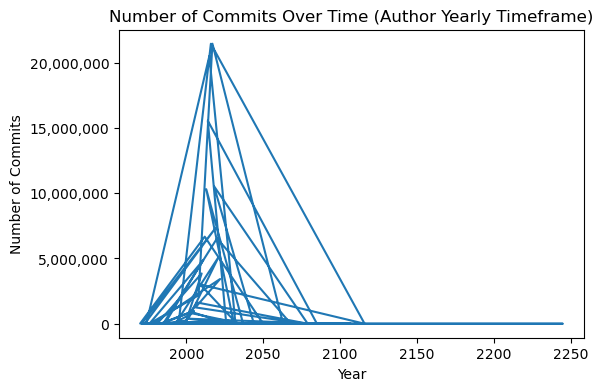

In [18]:
def Author_Time_Peaks_Valleys(df: DataFrame):
    # Aggregate data by year
    commit_df_auth_year_sec = df.groupBy(year('auth_time_sec').alias('year')).count()

    # Convert to pandas for plotting
    commit_df_auth_year_sec_pd = commit_df_auth_year_sec.toPandas()

    # Plot data
    fig, ax = plt.subplots(figsize=(6,4))
    formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)

    plt.plot(commit_df_auth_year_sec_pd['year'], commit_df_auth_year_sec_pd['count'])
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Commits')
    ax.set_title('Number of Commits Over Time (Author Yearly Timeframe)')
    plt.show()

Author_Time_Peaks_Valleys(com_df_1)

**3.2.2** **Committer-Time Seconds** of Peaks and Valleys

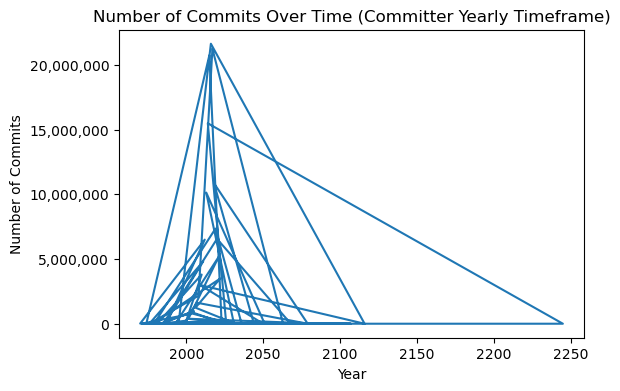

In [19]:
def Comitter_Time_Peaks_Valleys(df: DataFrame):
    # Aggregate data by year
    commit_df_com_year_sec = df.groupBy(year('com_time_sec').alias('year')).count()

    # Convert to pandas for plotting
    commit_df_com_year_sec_pd = commit_df_com_year_sec.toPandas()

    # Plot data
    fig, ax = plt.subplots(figsize=(6,4))
    formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)

    plt.plot(commit_df_com_year_sec_pd['year'], commit_df_com_year_sec_pd['count'])
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Commits')
    ax.set_title('Number of Commits Over Time (Committer Yearly Timeframe)')
    plt.show()
    
Comitter_Time_Peaks_Valleys(com_df_1)

**3.3** Data Colleciton Gaps

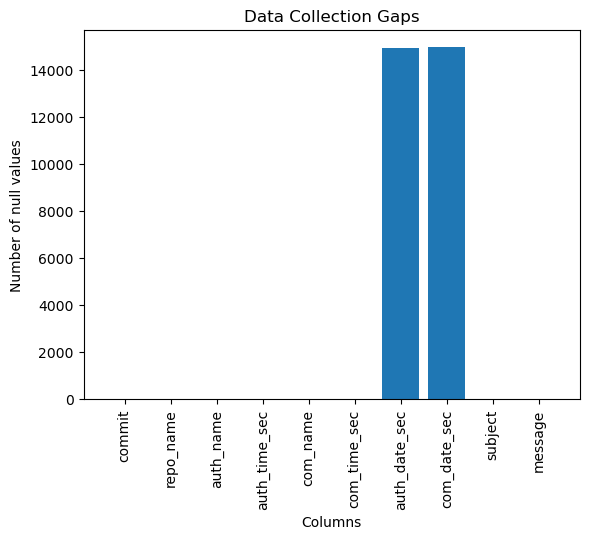

In [20]:
def Data_Collection_Gap(df: DataFrame):
    # Calculate the number of null values in each column
    null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]

    # Convert the null counts to a list
    null_counts_list = null_counts.asDict().values()

    # Create a bar plot
    plt.bar(df.columns, null_counts_list)
    plt.xlabel('Columns')
    plt.ylabel('Number of null values')
    plt.title('Data Collection Gaps')
    plt.xticks(rotation=90)
    plt.show()

Data_Collection_Gap(com_df_1)

The **Author-Date Seconds** & **Committer-Date Seconds** have the data gap collection because there have missing values in these columns 

**3.3.1** Handle the Data Collection Gaps

**3.3.1(1)** Author Date

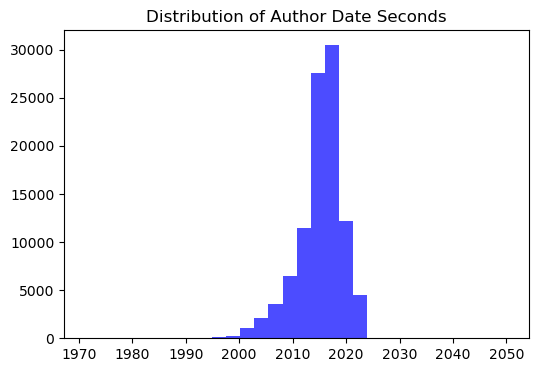

In [ ]:
def Author_Date(df: DataFrame, limit: int = 100000, bins: int = 30):
    """
    Function to plot a histogram of the 'auth_date_sec' column of a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame to plot.
    limit (int): The number of rows to consider for the plot. Default is 100000.
    bins (int): The number of bins to use in the histogram. Default is 30.
    """
    # Select 'auth_date_sec' and convert to pandas DataFrame
    auth_date_sec_pd = df.select("auth_date_sec").limit(limit).toPandas()

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(auth_date_sec_pd['auth_date_sec'], bins=bins, color='blue', alpha=0.7)
    plt.title('Distribution of Author Date Seconds')
    plt.show()

Author_Date(com_df_1)

**3.3.1(2)** Committer Date

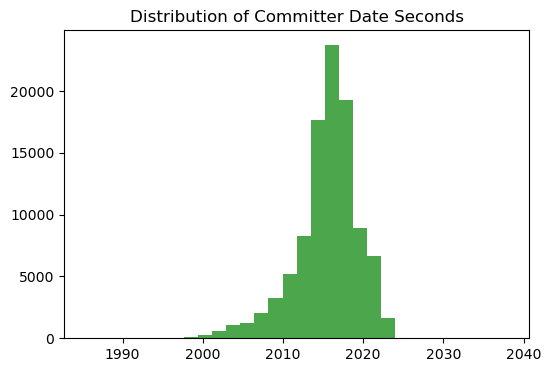

In [ ]:
def Committer_Date(df: DataFrame, limit: int = 100000, bins: int = 30):
    com_date_sec_pd = df.select("com_date_sec").limit(limit).toPandas()

    plt.figure(figsize=(6, 4))
    plt.hist(com_date_sec_pd['com_date_sec'], bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Committer Date Seconds')
    plt.show()

Committer_Date(com_df_1)

In [24]:
def Missing_Time(df: DataFrame):
    result = df.agg(
        count(lit(1)).alias('total_rows'),
        count(when(col('auth_date_sec').isNull(), 1)).alias('missing_auth_date_sec'),
        count(when(col('com_date_sec').isNull(), 1)).alias('missing_com_date_sec')
    ).collect()[0]

    # Extract the results
    total_rows = result['total_rows']
    missing_auth_date_sec = result['missing_auth_date_sec']
    missing_com_date_sec = result['missing_com_date_sec']

    # Calculate the percentage of missing values
    percentage_missing_auth_date_sec = round((missing_auth_date_sec / total_rows) * 100, 5)
    percentage_missing_com_date_sec = round((missing_com_date_sec / total_rows) * 100, 5)

    print(f'Percentage of missing values in auth_date_sec: {percentage_missing_auth_date_sec}%')
    print(f'Percentage of missing values in com_date_sec: {percentage_missing_com_date_sec}%')

Missing_Time(com_df_1)

Percentage of missing values in auth_date_sec: 0.00994%
Percentage of missing values in com_date_sec: 0.00997%


Both **Author-Date** and **Committer Date** are skewed left, meaning that it is not a symmetric distribution. Moreover, both variables of missing values are in very small proportions. Thus, meaninng that there are some data collection gap

Now, there is no missing values

**3.4** Do you see any outliers? Remove obvious outliers before plotting the timeline

In [16]:
from pyspark.sql.functions import col

def Struct_Time(com_df_1):
    # Convert the columns to unix timestamp (seconds since 1970-01-01 00:00:00 UTC)
    com_df_1 = com_df_1.withColumn('auth_time_sec', unix_timestamp(col('auth_time_sec')))
    com_df_1 = com_df_1.withColumn('com_time_sec', unix_timestamp(col('com_time_sec')))

    # Calculate the mean and standard deviation of the columns
    stats = com_df_1.select(
        mean(col('auth_time_sec')).alias('mean_auth_time_sec'),
        stddev(col('auth_time_sec')).alias('stddev_auth_time_sec'),
        mean(col('com_time_sec')).alias('mean_com_time_sec'),
        stddev(col('com_time_sec')).alias('stddev_com_time_sec')
    ).collect()[0]

    # Filter out outliers in one step
    com_df_1 = com_df_1.filter(
        (F.abs(F.col('auth_time_sec') - stats.mean_auth_time_sec) <= 3 * stats.stddev_auth_time_sec) &
        (F.abs(F.col('com_time_sec') - stats.mean_com_time_sec) <= 3 * stats.stddev_com_time_sec)
    )

    # Convert the unix timestamp back to date
    com_df_1 = com_df_1.withColumn('auth_time_sec', from_unixtime('auth_time_sec'))
    com_df_1 = com_df_1.withColumn('com_time_sec', from_unixtime('com_time_sec'))

    com_df_1 = com_df_1.withColumn("auth_time_sec", to_date("auth_time_sec"))
    com_df_1 = com_df_1.withColumn("com_time_sec", to_date("com_time_sec"))

    return com_df_1

com_df_1 = Struct_Time(com_df_1)
com_df_1 = com_df_1.drop('auth_date_sec', 'com_date_sec')

**3.4.1** Plotting the timeline after remove the outliers

**Histogram**: Plotting the **author-time second** and **committer-time second**

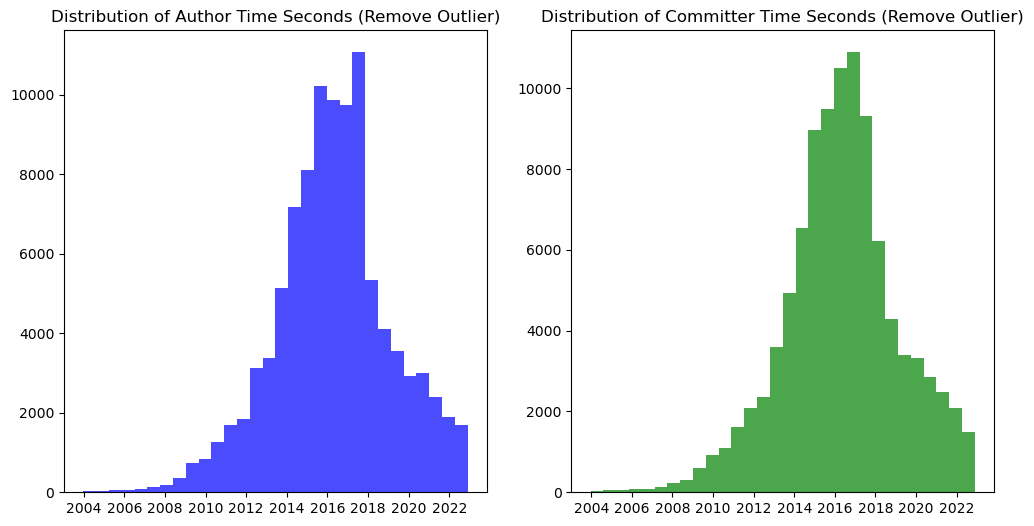

In [ ]:
def Time_Hist(df: DataFrame, limit: int = 100000):
    # Convert the columns to pandas series
    auth_time_sec_pd = df.select("auth_time_sec").limit(limit).toPandas()
    com_time_sec_pd = df.select("com_time_sec").limit(limit).toPandas()

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(auth_time_sec_pd['auth_time_sec'], bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of Author Time Seconds (Remove Outlier)')

    plt.subplot(1, 2, 2)
    plt.hist(com_time_sec_pd['com_time_sec'], bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Committer Time Seconds (Remove Outlier)')

    plt.show()

Time_Hist(com_df_1)

**Line Plot**: Plotting the **author-time second** and **committer-time second**

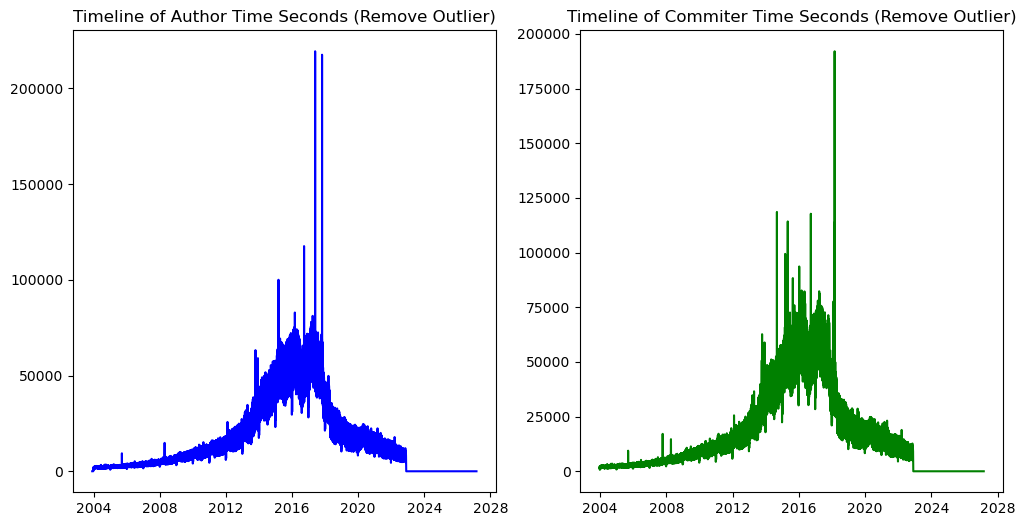

In [18]:
def Time_Line(df: DataFrame):
    # Count the number of records for each date
    auth_time_sec_count_pd = df.groupBy("auth_time_sec").count().orderBy("auth_time_sec").limit(100000).toPandas()
    com_time_sec_count_pd = df.groupBy("com_time_sec").count().orderBy("com_time_sec").limit(100000).toPandas()

    # Plot line plots
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(auth_time_sec_count_pd['auth_time_sec'], auth_time_sec_count_pd['count'], color='blue')
    plt.title('Timeline of Author Time Seconds (Remove Outlier)')

    plt.subplot(1, 2, 2)
    plt.plot(com_time_sec_count_pd['com_time_sec'], com_time_sec_count_pd['count'], color='green')
    plt.title('Timeline of Commiter Time Seconds (Remove Outlier)')

    plt.show()

Time_Line(com_df_1)

Both **Author Time Seconds** & **Committer Time Seconds** are becoming distribution symmetric after removing the outlier and missing values

**3.5** Do you see any spikes? Are these spikes caused by real activities / events?

**3.5.1** Identify the spikes in **Author Year Seconds Timeframe**

In [ ]:
commit_df_auth_year_sec = com_df_1.groupBy(year('auth_time_sec').alias('year')).count()

# Convert to pandas for plotting
commit_df_auth_year_sec_pd = commit_df_auth_year_sec.toPandas()

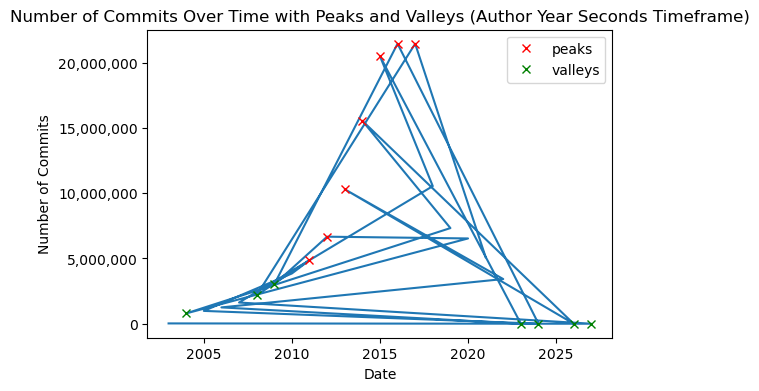

In [21]:
def Auth_Time_Spike(df):
    # Find indices of peaks
    auth_peak_indices, _ = find_peaks(df['count'])

    # Find indices of valleys
    auth_valley_indices, _ = find_peaks(-df['count'])

    # Plot data with peaks and valleys
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(df['year'], df['count'])
    ax.plot(df['year'][auth_peak_indices], df['count'][auth_peak_indices], 'x', color='r', label='peaks')
    ax.plot(df['year'][auth_valley_indices], df['count'][auth_valley_indices], 'x', color='g', label='valleys')

    # Format y-axis labels to display normal numbers
    formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Commits')
    ax.set_title('Number of Commits Over Time with Peaks and Valleys (Author Year Seconds Timeframe)')
    ax.legend()
    plt.show()

Auth_Time_Spike(commit_df_auth_year_sec_pd)

* In **Author Seconds Yearly** timeframe: **Peak** (Between 1998 and 2030), **Valley** Before 2000 and (Betwen 2040 and 2250)

**3.5.2** Identify the spikes in **Committer Year Seconds Timeframe**

In [23]:
commit_df_com_year_sec = com_df_1.groupBy(year('com_time_sec').alias('year')).count()

# Convert to pandas for plotting
commit_df_com_year_sec_pd = commit_df_com_year_sec.toPandas()

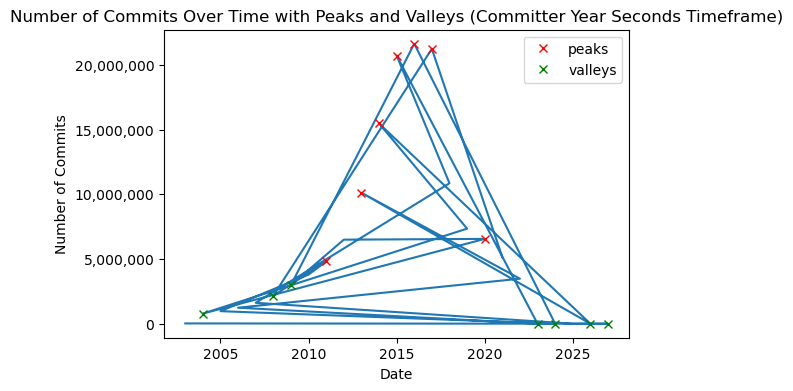

In [24]:
def Commit_Time_Spike(df):
    # Find indices of peaks
    com_peak_indices, _ = find_peaks(df['count'])

    # Find indices of valleys
    com_valley_indices, _ = find_peaks(-df['count'])

    # Plot data with peaks and valleys
    fig, ax = plt.subplots(figsize=(6,4))
    plt.plot(df['year'], df['count'])
    plt.plot(df['year'][com_peak_indices], df['count'][com_peak_indices], 'x', color='r', label='peaks')
    plt.plot(df['year'][com_valley_indices], df['count'][com_valley_indices], 'x', color='g', label='valleys')

    # Format y-axis labels to display normal numbers
    formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Commits')
    ax.set_title('Number of Commits Over Time with Peaks and Valleys (Committer Year Seconds Timeframe)')
    ax.legend()
    plt.show()

Commit_Time_Spike(commit_df_com_year_sec_pd)

* In **Committer Seconds Yearly** timeframe: **Peak** (Between 2000 and 2030), **Valley** Before 2000 and (Betwen 2040 and 2250)

### Only focused on between 2020-01-01 and 2022-12-31 to analysis below the questions and contexts

In [17]:
from pyspark.sql.functions import col

com_past = com_df_1.filter((col("com_time_sec") >= F.lit("2018-01-01")) & (col("com_time_sec") <= F.lit("2020-12-31")) & (col("auth_time_sec") >= F.lit("2018-01-01")) & (col("auth_time_sec") <= F.lit("2020-12-31")))
com_df_1 = com_df_1.filter((col("com_time_sec") >= F.lit("2020-01-01")) & (col("com_time_sec") <= F.lit("2022-12-31")) & (col("auth_time_sec") >= F.lit("2020-01-01")) & (col("auth_time_sec") <= F.lit("2022-12-31")))

#### 4. What are the most popular programming languages on GitHub?

* Did the trend oif most popular programing languages change over time?

Deep copy the **com_df_0** dataframe to do the programming language analysis

In [18]:
schema_copy_com_1 = copy.deepcopy(com_df_1.schema)

# Create a deep copy of the DataFrame
com_df_2 = com_df_1.rdd.toDF(schema_copy_com_1)

In [19]:
# Create a deep copy of the schema of lang_df
schema_copy_lang = copy.deepcopy(lang_df.schema)
lang_df_1 = lang_df.rdd.toDF(schema_copy_lang)
lang_df_2 = lang_df.rdd.toDF(schema_copy_lang)

**4.1** The most popular programming languages on GitHub

* **Overall** the most popular programming language on GitHub

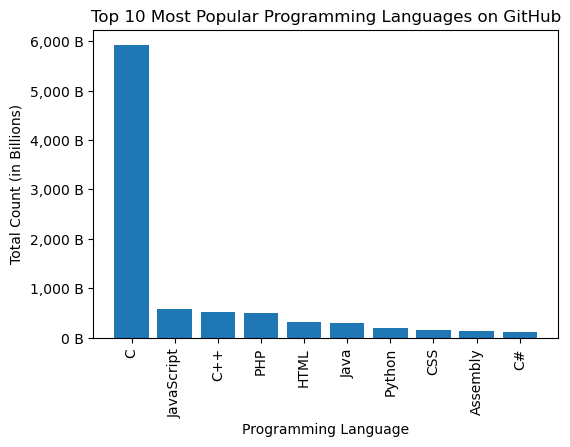

In [41]:
def top_pop_lang(df):
    # Extract language and count from the complex structure
    df = df.select(F.col("language_name").alias("language"), 
                             F.col("language_bytes").cast('int').alias("count"))

    # Group by language and sum the counts
    popular_languages = df.groupBy("language").agg(F.sum("count").alias("total_count"))

    # Sort by total_count in descending order
    popular_languages = popular_languages.sort(F.desc("total_count"))

    # Convert the top 10 popular languages to Pandas DataFrame
    top_10_languages = popular_languages.limit(10).toPandas()

    # Convert 'total_count' to billions
    top_10_languages['total_count'] = top_10_languages['total_count'] / 1e9

    # Plot the bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(top_10_languages['language'], top_10_languages['total_count'])

    # Format y-axis as billions
    plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',') + ' B'))

    plt.xlabel('Programming Language')
    plt.xticks(rotation = 90)
    plt.ylabel('Total Count (in Billions)')
    plt.title('Top 10 Most Popular Programming Languages on GitHub')

    plt.show()

top_pop_lang(lang_df_1)

* The most popular programming language is **C** on GitHub
* The **top five** of popular programming language are **C**, **JavaScript**, **C++**, **PHP**, **HTML** on GitHub

**4.2** Did the trend of most popular programing languages change over time?

* **2020 - 2022** Trend in C Programming Language

**4.2.1** **Commit Year**

* **C** Language changes over time  Betwefen **2020** and **2022** in commit year

In [42]:
def C_Trend_Com(lang_df: DataFrame, com_df: DataFrame):
    # Convert 'repo_name' from array<string> to string in com_df
    com_df = com_df.withColumn("repo_name", concat_ws(",", col("repo_name")))

    # Filter the data for the "C" programming language
    filtered_data = lang_df.join(com_df, lang_df.repo_name == com_df.repo_name, how='inner') \
        .filter(col("language_name") == "C")

    # Extract the year from the com_time_sec column
    filtered_data = filtered_data.withColumn("year", year(col("com_time_sec")))

    # Calculate the total language_bytes for the "C" programming language for each year
    total_language_bytes_per_year = filtered_data.groupBy("year").agg(sum("language_bytes")).orderBy("year")

    return total_language_bytes_per_year

C_language_bytes_per_year = C_Trend_Com(lang_df_2, com_df_2)

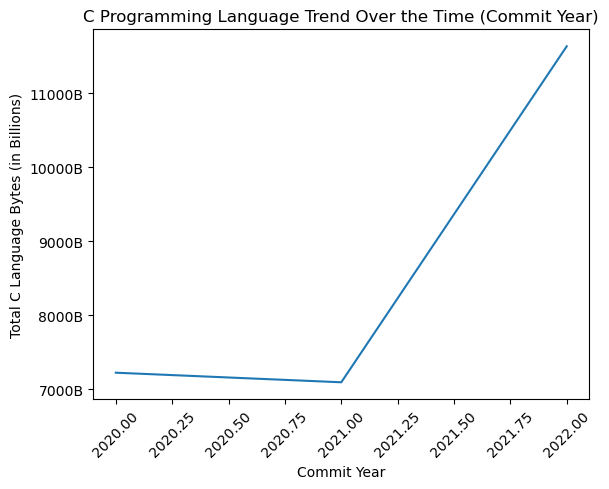

In [43]:
def C_Line_Trend_Com(df: DataFrame):
    # Convert the PySpark DataFrame to a Pandas DataFrame
    pdf = df.toPandas()

    # Create a function to format the y-axis numbers
    def y_format(x, pos):
        'The two args are the value and tick position'
        return '{:1.0f}B'.format(x * 1e-9)

    formatter = FuncFormatter(y_format)

    # Plot the line chart
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    ax.plot(pdf['year'], pdf['sum(language_bytes)'])
    plt.xlabel('Commit Year')
    plt.xticks(rotation = 45)
    plt.ylabel('Total C Language Bytes (in Billions)')
    plt.title('C Programming Language Trend Over the Time (Commit Year)')
    plt.show()

C_Line_Trend_Com(C_language_bytes_per_year)

**4.2.2** **Author Year**

In [44]:
def C_Trend_Auth(lang_df: DataFrame, com_df: DataFrame):
    # Convert 'repo_name' from array<string> to string in com_df
    com_df = com_df.withColumn("repo_name", concat_ws(",", col("repo_name")))

    # Filter the data for the "C" programming language and the given date range
    filtered_data = lang_df.join(com_df, lang_df.repo_name == com_df.repo_name, how='inner') \
        .filter(col("language_name") == "C")

    # Extract the year from the com_time_sec column
    filtered_data = filtered_data.withColumn("year", year(col("auth_time_sec")))

    # Calculate the total language_bytes for the "C" programming language for each year
    total_language_bytes_per_year = filtered_data.groupBy("year").agg(sum("language_bytes")).orderBy("year")

    return total_language_bytes_per_year

C_language_bytes_per_year_1 = C_Trend_Auth(lang_df_2, com_df_2)

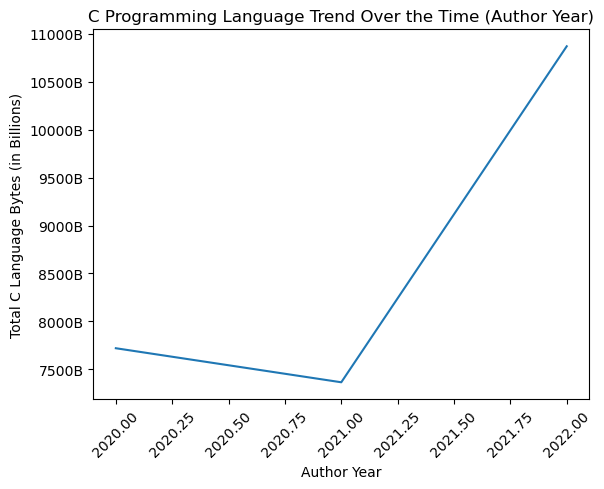

In [ ]:
def C_Line_Trend_Auth(df: DataFrame):
    # Convert the PySpark DataFrame to a Pandas DataFrame
    pdf = df.toPandas()

    # Create a function to format the y-axis numbers
    def y_format(x, pos):
        'The two args are the value and tick position'
        return '{:1.0f}B'.format(x * 1e-9)

    formatter = FuncFormatter(y_format)

    # Plot the line chart
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    ax.plot(pdf['year'], pdf['sum(language_bytes)'])
    plt.xlabel('Author Year')
    plt.xticks(rotation = 45)
    plt.ylabel('Total C Language Bytes (in Billions)')
    plt.title('C Programming Language Trend Over the Time (Author Year)')
    plt.show()

C_Line_Trend_Auth(C_language_bytes_per_year_1)

* **C** Language changes over time in author year

#### 5. What is the distribution of licenses across GitHub repositories?

* Any certain programming languages that are more likely to be associated with a particular license? 

In [20]:
# Create a deep copy of the DataFrame
com_df_3 = com_df_1.rdd.toDF(schema_copy_com_1)

# Create a deep copy of the schema of lang_df
schema_copy_lang = copy.deepcopy(lang_df.schema)
lang_df_3 = lang_df.rdd.toDF(schema_copy_lang)

# Create a deep copy of schema of lic_df
schema_copy_lic = copy.deepcopy(lic_df.schema)
lic_df_1 = lic_df.rdd.toDF(schema_copy_lic)

**5.1** Distribution of licenses across GitHub repositories

* Betweenn **2020** and **2022** distribution of licenses across GitHub respositories

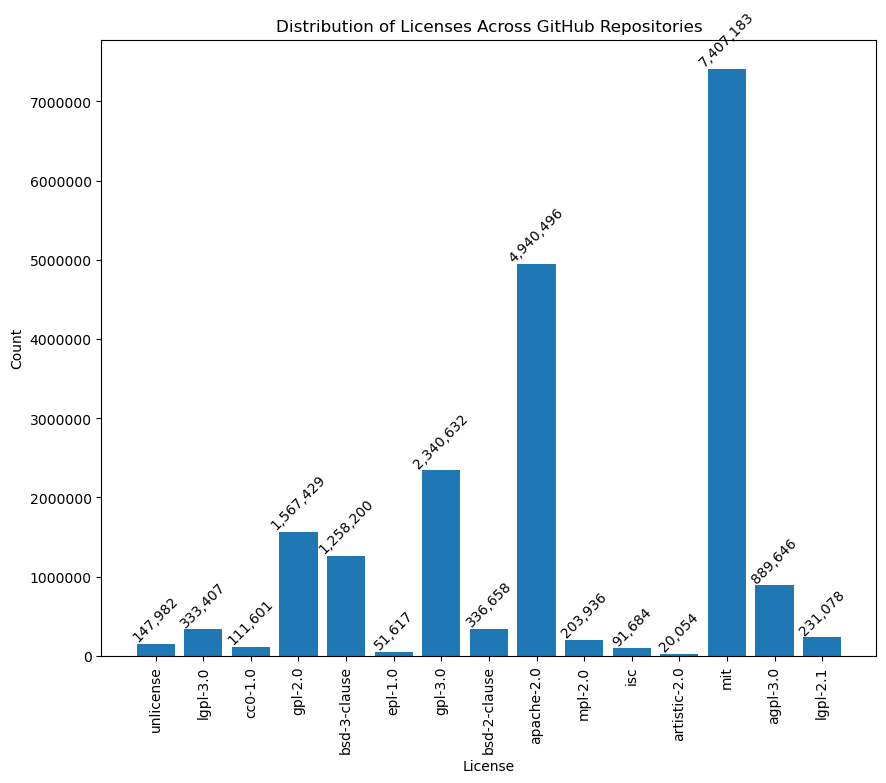

In [21]:
def Lic_Hist(lic_df: DataFrame, com_df: DataFrame):
    # Convert 'repo_name' from array<string> to string in com_df
    com_df = com_df.withColumn("repo_name", concat_ws(",", col("repo_name")))

    # Join lic_df and com_df on 'repo_name'
    joined_df = lic_df.join(com_df, lic_df.repo_name == com_df.repo_name, how='inner')

    # Group by 'license' and 'auth_name' to count
    license_distribution = joined_df.groupBy("license").count().toPandas()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(license_distribution['license'], license_distribution['count'])

    # Convert y-axis to normal numbers
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

    # Add count number for each bin
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, "{:,}".format(int(yval)), ha='center', va='bottom', rotation=45)

    # Rotate x-axis labels
    plt.xticks(rotation = 90)

    plt.xlabel('License')
    plt.ylabel('Count')
    plt.title('Distribution of Licenses Across GitHub Repositories')
    plt.show()

Lic_Hist(lic_df_1, com_df_3)

**5.2** Any certain programming languages that are more likely to be associated with a particular license

In [22]:
from pyspark.sql.functions import col

def Lic_Lang(lang_df_3: DataFrame, lic_df_1: DataFrame, com_df_3: DataFrame) -> DataFrame:
    # Convert 'repo_name' from array<string> to string in com_df
    com_df_3 = com_df_3.withColumn("repo_name", concat_ws(",", col("repo_name")))

    # Join the dataframes on repo_name
    joined_df_2 = lang_df_3.join(lic_df_1, on='repo_name', how='inner')
    joined_df_2 = joined_df_2.join(com_df_3, on='repo_name', how='inner')

    # Select the necessary columns
    language_df_1 = joined_df_2.select('repo_name', 'license', 'language_name')

    # Group by 'license', 'language_name', and 'auth_name' and count the number of 'repo_name'
    count_df_1 = language_df_1.groupBy('license', 'language_name').agg(count('repo_name').alias('count'))

    # Create a window partitioned by 'language_name' and ordered by the count in descending order
    window_4 = Window.partitionBy('language_name').orderBy(count_df_1['count'].desc())

    # Select the top 10 for each language
    top_5_df_lic = count_df_1.select('*', row_number().over(window_4).alias('rank')).filter('rank <= 5')

    return top_5_df_lic

top_5_df_lic = Lic_Lang(lang_df_3, lic_df_1, com_df_3)
top_5_df_lic.show(30)

+------------+-------------+------+----+
|     license|language_name| count|rank|
+------------+-------------+------+----+
|         mit|           C#|742183|   1|
|  apache-2.0|           C#|218551|   2|
|     gpl-3.0|           C#|123381|   3|
|     gpl-2.0|           C#| 74664|   4|
|bsd-3-clause|           C#| 40741|   5|
|     gpl-2.0|        Cairo|   290|   1|
|         mit|          EJS|136997|   1|
|  apache-2.0|          EJS| 42672|   2|
|    agpl-3.0|          EJS| 34010|   3|
|     gpl-2.0|          EJS| 23321|   4|
|bsd-3-clause|          EJS| 17401|   5|
|  apache-2.0|           F*|  8970|   1|
|     gpl-3.0|           F*|  1027|   2|
|         mit|           F*|   282|   3|
|     gpl-2.0|           F*|    46|   4|
|bsd-2-clause|           F*|     4|   5|
|     gpl-2.0|        Gleam|   290|   1|
|         mit|        Gleam|   242|   2|
|     gpl-2.0|        Grace|    32|   1|
|     gpl-3.0|        Grace|     9|   2|
|  apache-2.0|       JSONiq|  1052|   1|
|         mit|  

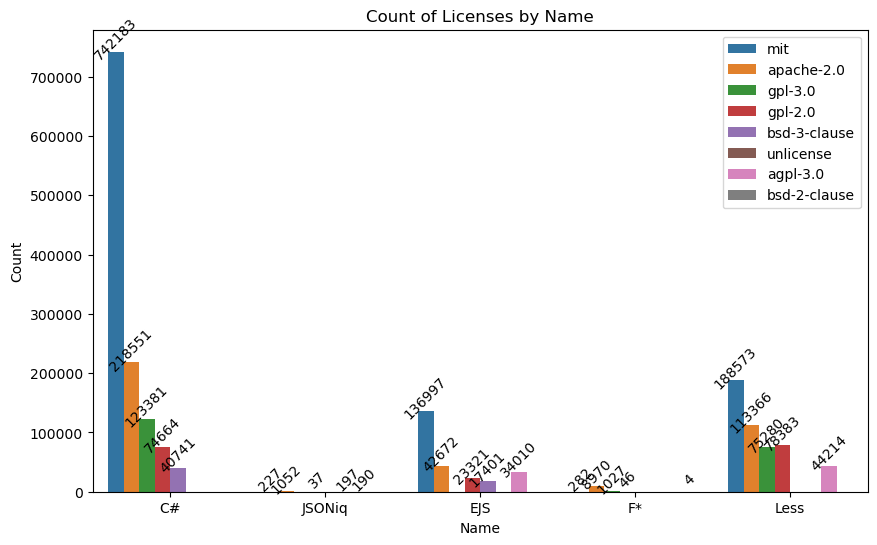

In [23]:
def Lic_Lang_Plot(df, names):
    # Filter the DataFrame
    filtered_df = df.filter(df.language_name.isin(names))

    # Collect a small amount of data to the driver node
    data = filtered_df.collect()

    # Convert the collected data to a Pandas DataFrame
    pandas_df = pd.DataFrame(data, columns=filtered_df.columns)

    # Plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(data=pandas_df, x='language_name', y='count', hue='license')

    # Add count annotations to the bars
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       rotation=45)  # Rotate the count annotations by 45 degrees

    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    plt.title('Count of Licenses by Name')
    plt.show()

names_4 = ['C#', 'EJS', 'F*', 'JSONiq', 'Less']
Lic_Lang_Plot(top_5_df_lic, names_4)

* There is no certain **programming languages** that are most likely to be associated with a particular **license**. In other words, each of the **license** has **multiple** programming languages

* In this case, **mit** license is the largest proportion in **C#** programming language between 2020 and 2022

#### 6. What can you tell about the most popular and most rapidly growing repositories? 

* Is there certain technology that is driving popularity or explosive growth?
* Are these associated with Big TechLinks to an external site., who are open sourcing the technology?
* Are there any technological breakthroughs that are driving this brisk adoption?

In [34]:
# Create a deep copy of the DataFrame
com_df_4 = com_df_1.rdd.toDF(schema_copy_com_1)
com_df_5 = com_df_1.rdd.toDF(schema_copy_com_1)
com_df_6 = com_df_1.rdd.toDF(schema_copy_com_1)

# Create a deep copy from schema lang_df
lang_df_4 = lang_df.rdd.toDF(schema_copy_lang)

# Create a deep copy from schema lic_df
schema_copy_lic = copy.deepcopy(lic_df.schema)
lic_df_2 = lic_df.rdd.toDF(schema_copy_lic)

**6.1** Technologies driving popularity or explosive growth

In [22]:
def Top_5_Tech(df):
    
    # Perform the same preprocessing as in Freq_Tech
    df = df.withColumn("technology", split(col("repo_name")[0], "/")[1])
    df = df.withColumn("technology", split(col("technology"), "-")[0])
    df = df.withColumn("technology", regexp_replace(col("technology"), "http\S+", ""))
    df = df.withColumn("technology", regexp_replace(col("technology"), "[^a-zA-Z\s]", ""))
    df = df.withColumn("technology", trim(col("technology")))
    df = df.na.drop(subset=["technology", "technology"])
    df = df.withColumn("com_time_sec", year(df["com_time_sec"]))

    # Filter out the "update" value in the 'technology' column
    # Because "update" is not the technology
    df = df.filter(col("technology") != "update")

    # Count each technology and sort by count in descending order
    result_tech = df.groupBy("technology").count()
    result_tech = result_tech.sort(desc("count"))

    # Return the top 5 technologies
    return result_tech.limit(5)

top_5_tech = Top_5_Tech(com_df_4)
top_5_tech.show()

+----------+------+
|technology| count|
+----------+------+
|  chromium|349925|
|  homebrew|281725|
|    relint|241616|
|   nixpkgs|220430|
|     linux|200867|
+----------+------+



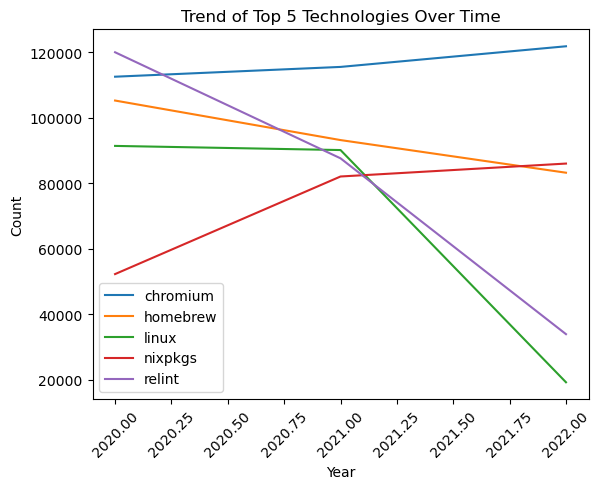

In [ ]:
def plot_tech_trends(df, tech_list):
    # Filter the DataFrame to include only the specified technologies
    # Perform the same preprocessing as in Freq_Tech
    df = df.withColumn("technology", split(col("repo_name")[0], "/")[1])
    df = df.withColumn("technology", split(col("technology"), "-")[0])
    df = df.withColumn("technology", regexp_replace(col("technology"), "http\S+", ""))
    df = df.withColumn("technology", regexp_replace(col("technology"), "[^a-zA-Z\s]", ""))
    df = df.withColumn("technology", trim(col("technology")))
    df = df.na.drop(subset=["technology", "technology"])
    df = df.filter(col("technology").isin(tech_list))
    df = df.filter(col("technology") != "update")

    # Group by technology and year, and count the occurrences
    tech_year_df = df.groupBy("technology", year("com_time_sec").alias("year")).count()

    # Convert the PySpark DataFrame to a pandas DataFrame for plotting
    pd_df = tech_year_df.toPandas()

    # Pivot the data for line plot
    pd_df = pd_df.pivot(index='year', columns='technology', values='count')

    # Plot the data
    pd_df.plot(kind='line')
    plt.title('Trend of Top 5 Technologies Over Time')
    plt.xlabel('Year')
    plt.xticks(rotation = 45)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Specify the list of technologies you want to plot
tech_list = ["chromium", "linux", "homebrew", "relint", "nixpkgs"]

# Call the function with the specified technologies
plot_tech_trends(com_df_4, tech_list)

* Find the top five of popluar technologies (**chromium**, **homebrew**, **relint**, **nixpkgs**, **linus**)
* Then, visualize the most top 5 populuar technologies change over the time
* The most popular technology is the **Chromium**.
* **Chromium** slightly increase at 2020.
* **Linux** and **Relint** signifiantly decrease at the end of 2020.

**6.2** Are these associated with Big TechLinks to an external site., who are open sourcing the technology?

* Alphabet, Amazon, Apple, Meta, Microsoft

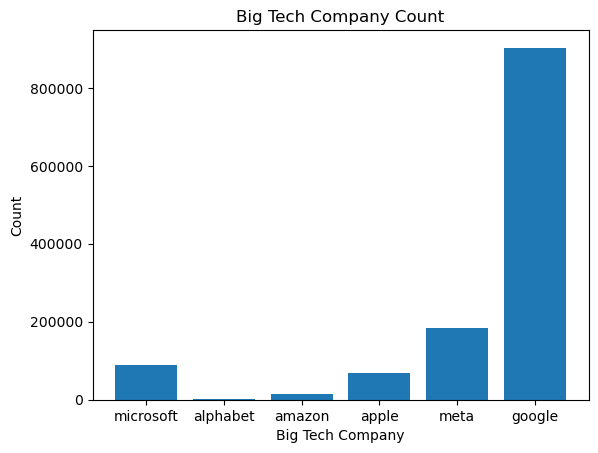

In [ ]:
def Big_Tech_Plot(com_df_5):
    # Explode the 'repo_name' column
    com_df_5 = com_df_5.select("*", explode(com_df_5.repo_name).alias("exploded_repo_name"))

    big_tech = ['alphabet', 'amazon', 'apple', 'meta', 'microsoft', 'google']

    # Create a new column 'big_tech' that indicates if the repository is associated with a Big Tech company
    com_df_5 = com_df_5.withColumn('big_tech', when(col('exploded_repo_name').rlike('|'.join(big_tech)), lit(True)).otherwise(lit(False)))

    # Filter the dataframe by the 'big_tech' column
    big_tech_commits = com_df_5.filter(com_df_5['big_tech'] == True)

    # Extract only the Big Tech company names from the 'exploded_repo_name' column
    big_tech_commits = big_tech_commits.withColumn('exploded_repo_name', regexp_extract('exploded_repo_name', f'(?i)({"|".join(big_tech)})', 1))

    big_tech_commits = big_tech_commits.withColumn("exploded_repo_name", lower(big_tech_commits["exploded_repo_name"]))

    # Count the occurrences of each Big Tech company
    big_tech_counts = big_tech_commits.groupBy('exploded_repo_name').count()

    # Collect the data to the driver node
    big_tech_counts_info = big_tech_counts.collect()

    # Separate the data into two lists for plotting
    companies = [row['exploded_repo_name'] for row in big_tech_counts_info]
    counts = [row['count'] for row in big_tech_counts_info]

    # Create the bar plot
    plt.bar(companies, counts)
    plt.xlabel('Big Tech Company')
    plt.ylabel('Count')
    plt.title('Big Tech Company Count')
    plt.show()

Big_Tech_Plot(com_df_5)

In [27]:
def Big_Tech_List_Assoc(df):
    big_tech = ['alphabet', 'amazon', 'apple', 'meta', 'microsoft', 'google']
    tech_list = ["chromium", "linux", "homebrew", "relint", "nixpkgs"]

    df = df.select("*", explode(df.repo_name).alias("exploded_repo_name"))
    df = df.withColumn('big_tech', when(col('exploded_repo_name').rlike('|'.join(big_tech)), lit(True)).otherwise(lit(False)))
    df = df.withColumn('technology', when(col('exploded_repo_name').rlike('|'.join(tech_list)), lit(True)).otherwise(lit(False)))
    df = df.filter((df['big_tech'] == True) & (df['technology'] == True))
    df = df.withColumn('big_tech', regexp_extract('exploded_repo_name', f'(?i)({"|".join(big_tech)})', 1))
    df = df.withColumn('technology', regexp_extract('exploded_repo_name', f'(?i)({"|".join(tech_list)})', 1))
    df = df.groupBy('big_tech', 'technology').count()

    return df

Big_Tech_List_Assoc(com_df_6).show()

+---------+----------+-----+
| big_tech|technology|count|
+---------+----------+-----+
|microsoft|     linux|    2|
|   google|     linux|    6|
|     meta|     linux| 1753|
| alphabet|  homebrew|  310|
|   google|  chromium| 1038|
+---------+----------+-----+



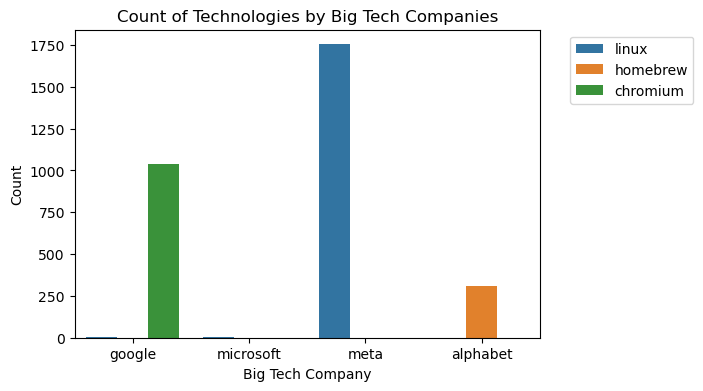

In [ ]:
def Big_Tech_List_Plot(df):
    # Convert PySpark DataFrame to Pandas DataFrame
    pandas_df = df.toPandas()

    # Create a figure and axis for the plot
    plt.figure(figsize=(6, 4))

    # Create a barplot
    sns.barplot(x='big_tech', y='count', hue='technology', data=pandas_df)

    # Set plot title and labels
    plt.title('Count of Technologies by Big Tech Companies')
    plt.xlabel('Big Tech Company')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('Count')

    # Show the plot
    plt.show()
    
df_big_tech = Big_Tech_List_Assoc(com_df_6)
Big_Tech_List_Plot(df_big_tech)

* **Linux** and **Homebrew** are associate with big tech
* But **relint**, **nixpkgs** are not associate with big tech
* **Meta** company has the largest association with the **Linux** technology (software)

</br>
They are all open source technologies:

* 1. **Chromium**: It is an open-source browser project that aims to build a safer, faster, and more stable way for all users to experience the web. It is primarily developed and maintained by Google and provides the vast majority of code for the Google Chrome browser
</br>
* 2. **Linux**: It is the best-known and most-used open source operating system. It is software that sits underneath all of the other software on a computer, receiving requests from those programs and relaying these requests to the computer’s hardware.
</br>
* 3. **Homebrew**: It is a free and open-source software package management system that simplifies the installation of software on Apple's macOS and Linux operating systems. It is written in Ruby and is hosted by the Open Source Collective.
</br>
* 4. **Relint**: It is a tool used for linting, which is the process of running a program that will analyze code for potential errors. It is an Elisp (Emacs Lisp) regular expression lint tool and a Python tool for writing your own linting rules using regular expressions.
</br>
* 5. **Nixpkgs**: It is a collection of over 80,000 software packages that can be installed with the Nix package manager. Nix is a powerful package manager for Linux and other Unix systems that makes package management reliable and reproducible.

**6.3** Are there any technological breakthroughs that are driving this brisk adoption?

In [ ]:
from pyspark.sql.functions import col
def Top_5_Tech_Past(df):
    
    # Perform the same preprocessing as in Freq_Tech
    df = df.withColumn("technology", split(col("repo_name")[0], "/")[1])
    df = df.withColumn("technology", split(col("technology"), "-")[0])
    df = df.withColumn("technology", regexp_replace(col("technology"), "http\S+", ""))
    df = df.withColumn("technology", regexp_replace(col("technology"), "[^a-zA-Z\s]", ""))
    df = df.withColumn("technology", trim(col("technology")))
    df = df.na.drop(subset=["technology", "technology"])
    df = df.withColumn("com_time_sec", year(df["com_time_sec"]))

    # Filter out the "update" value in the 'technology' column
    # Because "update" is not the technology
    df = df.filter(col("technology") != "update")

    # Count each technology and sort by count in descending order
    result_tech = df.groupBy("technology").count()
    result_tech = result_tech.sort(desc("count"))

    # Return the top 5 technologies
    return result_tech.limit(5)

top_5_tech_past = Top_5_Tech_Past(com_past)
top_5_tech_past.show()

+----------+------+
|technology| count|
+----------+------+
|  chromium|315043|
|  dotfiles|296110|
|     linux|276430|
|  homebrew|224655|
|     react|202359|
+----------+------+



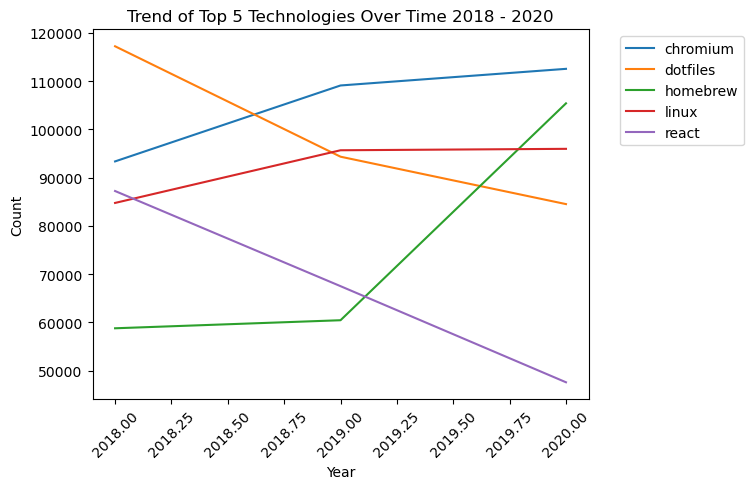

In [ ]:
def plot_tech_trends_past(df, tech_list):
    # Filter the DataFrame to include only the specified technologies
    # Perform the same preprocessing as in Freq_Tech
    df = df.withColumn("technology", split(col("repo_name")[0], "/")[1])
    df = df.withColumn("technology", split(col("technology"), "-")[0])
    df = df.withColumn("technology", regexp_replace(col("technology"), "http\S+", ""))
    df = df.withColumn("technology", regexp_replace(col("technology"), "[^a-zA-Z\s]", ""))
    df = df.withColumn("technology", trim(col("technology")))
    df = df.na.drop(subset=["technology", "technology"])
    df = df.filter(col("technology").isin(tech_list))
    df = df.filter(col("technology") != "update")

    # Group by technology and year, and count the occurrences
    tech_year_df = df.groupBy("technology", year("com_time_sec").alias("year")).count()

    # Convert the PySpark DataFrame to a pandas DataFrame for plotting
    pd_df = tech_year_df.toPandas()

    # Pivot the data for line plot
    pd_df = pd_df.pivot(index='year', columns='technology', values='count')

    # Plot the data
    pd_df.plot(kind='line')
    plt.title('Trend of Top 5 Technologies Over Time 2018 - 2020')
    plt.xlabel('Year')
    plt.xticks(rotation = 45)
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Specify the list of technologies you want to plot
tech_list_past = ["chromium", "linux", "homebrew", "dotfiles", "react"]

# Call the function with the specified technologies
plot_tech_trends_past(com_past, tech_list_past)

In [30]:
def Big_Tech_List_Assoc_past(df):
    big_tech = ['alphabet', 'amazon', 'apple', 'meta', 'microsoft', 'google']
    tech_list_past = ["chromium", "linux", "homebrew", "dotfiles", "react"]

    df = df.select("*", explode(df.repo_name).alias("exploded_repo_name"))
    df = df.withColumn('big_tech', when(col('exploded_repo_name').rlike('|'.join(big_tech)), lit(True)).otherwise(lit(False)))
    df = df.withColumn('technology', when(col('exploded_repo_name').rlike('|'.join(tech_list_past)), lit(True)).otherwise(lit(False)))
    df = df.filter((df['big_tech'] == True) & (df['technology'] == True))
    df = df.withColumn('big_tech', regexp_extract('exploded_repo_name', f'(?i)({"|".join(big_tech)})', 1))
    df = df.withColumn('technology', regexp_extract('exploded_repo_name', f'(?i)({"|".join(tech_list_past)})', 1))
    df = df.groupBy('big_tech', 'technology').count()

    return df

Big_Tech_List_Assoc_past(com_past).show()

+---------+----------+-----+
| big_tech|technology|count|
+---------+----------+-----+
|   google|     react| 2502|
| alphabet|  dotfiles|   29|
|    apple|     react|   29|
|microsoft|     linux|    3|
|   google|     linux|    3|
|     meta|  homebrew|    2|
|     meta|     linux| 2721|
|     meta|     react|   70|
| alphabet|  homebrew|  313|
|     meta|  dotfiles|  297|
|   google|  chromium| 2048|
+---------+----------+-----+



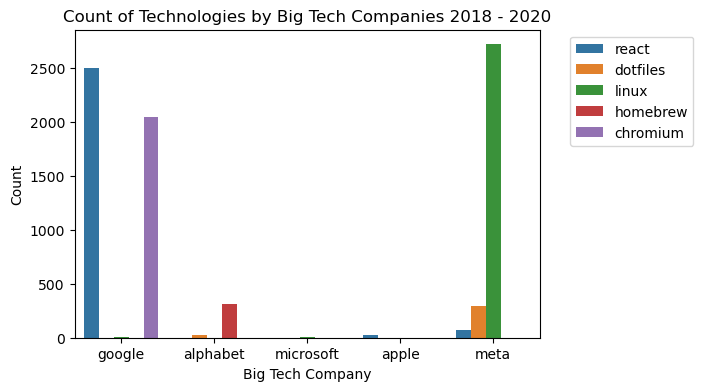

In [31]:
def Big_Tech_List_Plot_Past(df):
    # Convert PySpark DataFrame to Pandas DataFrame
    pandas_df = df.toPandas()

    # Create a figure and axis for the plot
    plt.figure(figsize=(6, 4))

    # Create a barplot
    sns.barplot(x='big_tech', y='count', hue='technology', data=pandas_df)

    # Set plot title and labels
    plt.title('Count of Technologies by Big Tech Companies 2018 - 2020')
    plt.xlabel('Big Tech Company')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('Count')

    # Show the plot
    plt.show()
    
df_big_tech_past = Big_Tech_List_Assoc_past(com_past)
Big_Tech_List_Plot_Past(df_big_tech_past)

#### 7. Identify what technologies are most frequently associated with Data Science or AI projects

* Did these technologies change over time?

In [20]:
schema_copy_file_1 = copy.deepcopy(file_df.schema)

com_df_7 = com_df_1.rdd.toDF(schema_copy_com_1)
file_df_1 = file_df.rdd.toDF(schema_copy_file_1)

In [21]:
com_df_7_file = com_df_7.select("repo_name", "com_time_sec", "auth_time_sec", "subject")
com_df_7_file.show(5)

+--------------------+------------+-------------+--------------------+
|           repo_name|com_time_sec|auth_time_sec|             subject|
+--------------------+------------+-------------+--------------------+
|[conda-forge/feed...|  2022-03-15|   2022-03-15|Updated the qceng...|
|[conda-forge/feed...|  2022-01-26|   2022-01-26|Updated the mailc...|
|[conda-forge/feed...|  2021-09-23|   2021-09-23|Updated the mypy_...|
|[conda-forge/feed...|  2022-08-29|   2022-08-29|Updated the gitig...|
|[conda-forge/feed...|  2020-10-12|   2020-10-12|Updated the conda...|
+--------------------+------------+-------------+--------------------+
only showing top 5 rows



In [ ]:
# Modify the code to find keywords in the subject column
df = com_df_7_file.withColumn("technology", F.split(F.col("repo_name")[0], "/")[1])
df = df.withColumn("technology", F.split(F.col("technology"), "-")[0])
df = df.withColumn("technology", F.regexp_replace(F.col("technology"), "http\S+", ""))
df = df.withColumn("technology", F.regexp_replace(F.col("technology"), "[^a-zA-Z\s]", ""))
df = df.withColumn("technology", F.trim(F.col("technology")))

# Ensure consistent case for technology names
df = df.withColumn("technology", F.lower(F.col("technology")))

# Fill null values in the technology column
df = df.na.fill({'technology': 'unknown'})

df = df.withColumn("com_time_sec", F.year(df["com_time_sec"]))

keywords = ['data science', 'machine learning', 'artificial intelligence', 'deep learning', 'neural network']
keyword_expr = [F.when(F.col("subject").like(f"%{k}%"), F.lit(k)).otherwise(F.lit(None)).alias(k) for k in keywords]
df = df.select("*", *keyword_expr)

# Output the most frequently associated technology terms for each keyword
for keyword in keywords:
    keyword_tech_counts = df.filter(F.col(keyword) == keyword).groupBy("technology").count().sort(F.col("count").desc()).withColumnRenamed("count", keyword).show(1)

+------------+------------+
|  technology|data science|
+------------+------------+
|pythonvscode|          11|
+------------+------------+
only showing top 1 row



+----------+----------------+
|technology|machine learning|
+----------+----------------+
|     azure|              22|
+----------+----------------+
only showing top 1 row



+----------------+-----------------------+
|      technology|artificial intelligence|
+----------------+-----------------------+
|translateproject|                      2|
+----------------+-----------------------+
only showing top 1 row



+--------------------+-------------+
|          technology|deep learning|
+--------------------+-------------+
|hanhandatascience...|           12|
+--------------------+-------------+
only showing top 1 row



+----------+--------------+
|technology|neural network|
+----------+--------------+
|      fast|            15|
+----------+--------------+
only showing top 1 row



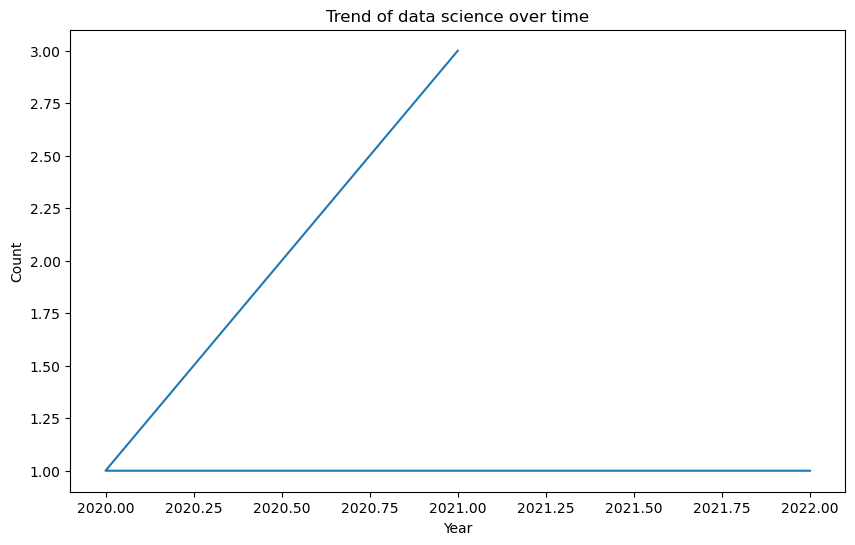

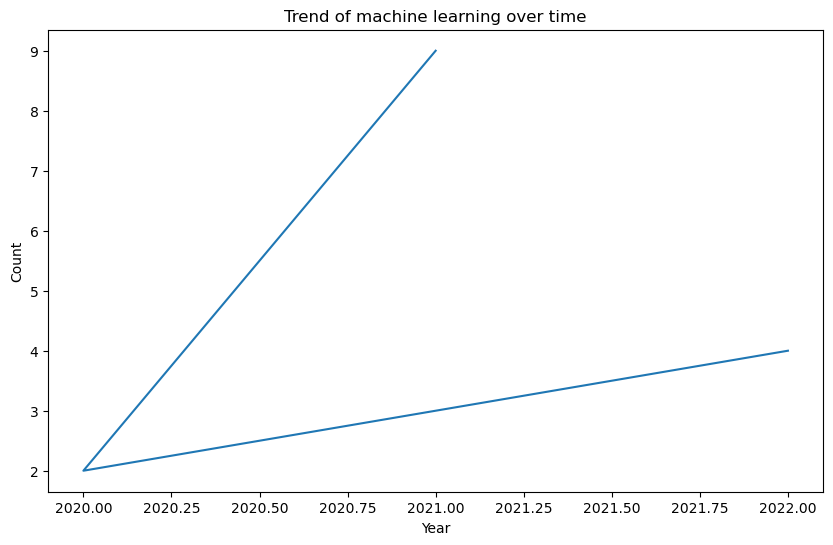

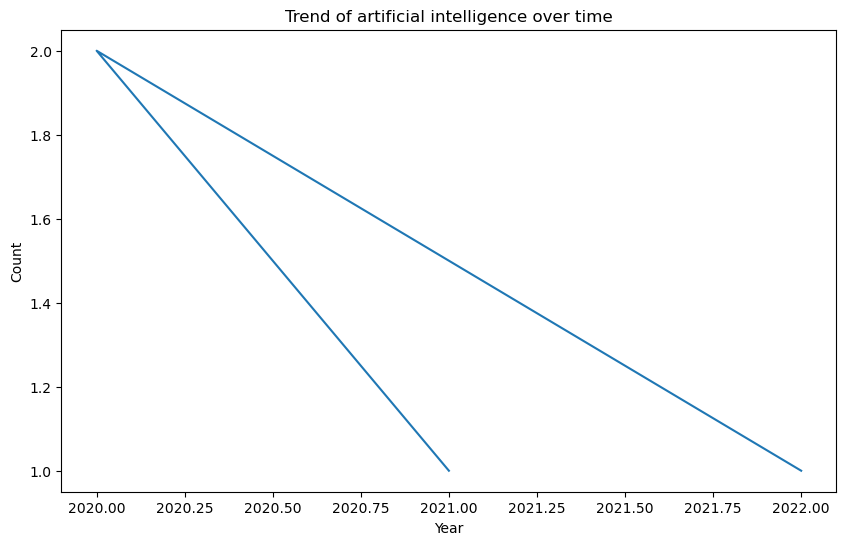

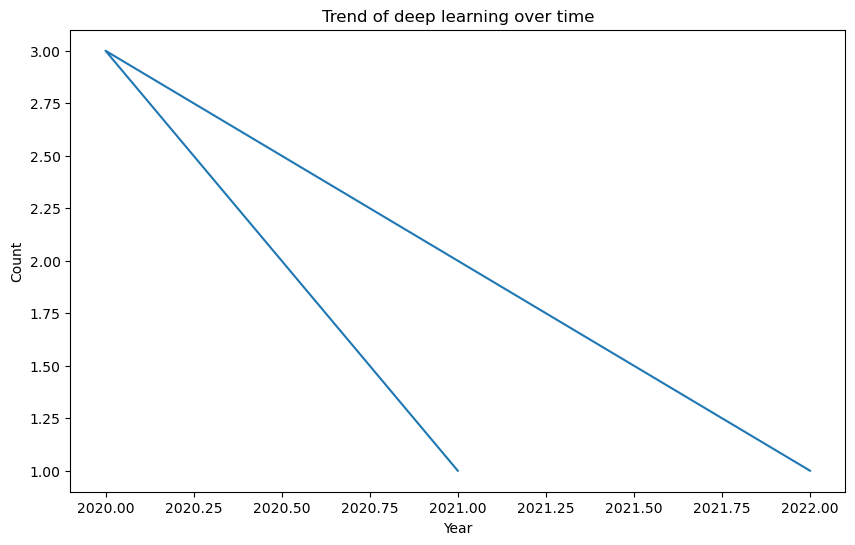

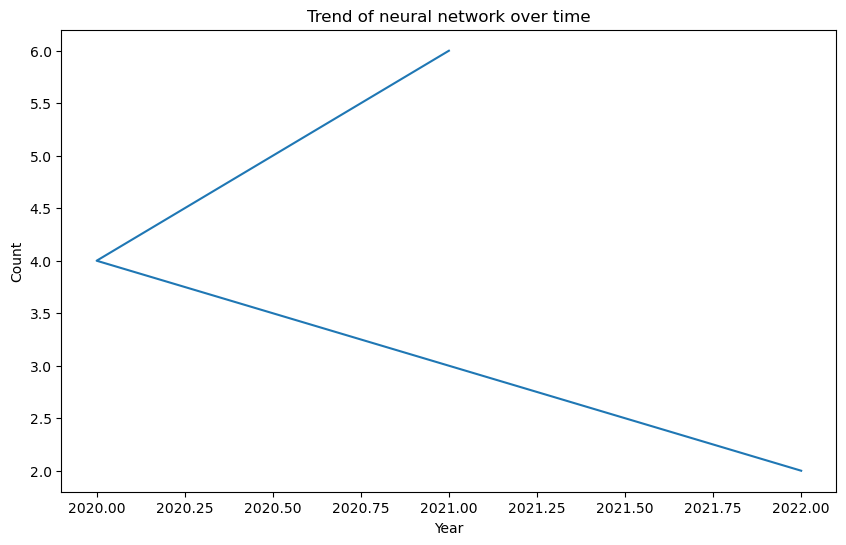

In [ ]:
# Create an empty dictionary to store the results
results = {}

# Loop over the keywords
for keyword in keywords:
    # Filter rows where the keyword column equals the keyword
    # Group by 'technology' and 'com_time_sec', and count the occurrences
    # Sort by 'com_time_sec' and take the technology with the highest count for each year
    keyword_tech_counts = df.filter(F.col(keyword) == keyword)\
                            .groupBy("technology", "com_time_sec")\
                            .count()\
                            .sort("com_time_sec", F.col("count").desc())\
                            .dropDuplicates(["com_time_sec"])
    
    # Collect the data to the driver node and convert to pandas for plotting
    pd_df = keyword_tech_counts.toPandas()
    
    # Store the result in the dictionary
    results[keyword] = pd_df

# Plot the results
for keyword, data in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(data['com_time_sec'], data['count'])
    plt.title(f'Trend of {keyword} over time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()

#### 8. What are the most frequent reasons for committing into GitHub repositories?

* Is this new technology development, bug fix, etc.

**8.1** Is this new technology development, bug fix, etc.

In [35]:
# Create a deep copy of the DataFrame
com_df_8 = com_df_1.rdd.toDF(schema_copy_com_1)

# Create a deep copy from schema lic_df
lic_df_3 = lic_df.rdd.toDF(schema_copy_lic)

<Figure size 600x400 with 0 Axes>

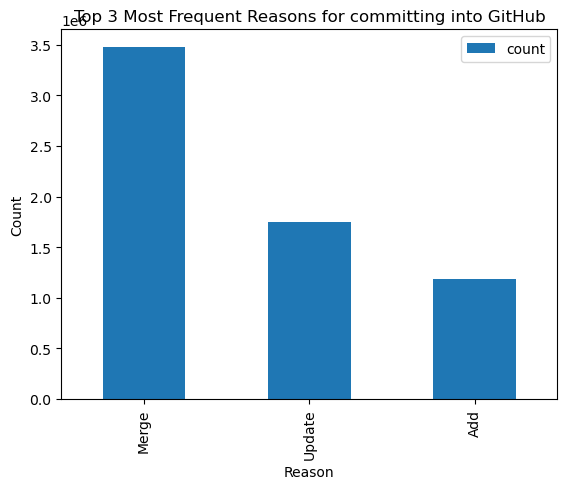

In [ ]:
def Freq_Reason(df, column):
    # Remove special characters
    df_clean = df.select(column).withColumn(column, regexp_replace(col(column), '[^a-zA-Z0-9\s]', ''))

    # Keep only the first term
    df_first_term = df_clean.withColumn(column, split(col(column), ' ')[0])

    # Count each term
    df_count = df_first_term.groupBy(column).count()

    # Order by count in descending order and show the top 3
    df_top_3 = df_count.orderBy(desc('count')).limit(3)
    df_top_3_pd = df_top_3.toPandas()

    # Plot the top 3 most frequent terms
    plt.figure(figsize=(6, 4))
    df_top_3_pd.plot(kind='bar', x=column, y='count')
    plt.title('Top 3 Most Frequent Reasons for committing into GitHub')
    plt.xlabel('Reason')
    plt.ylabel('Count')
    plt.show()

Freq_Reason(com_df_8, 'subject')

* The top three reason for committing into GitHub repositories are **Merge**, **Update** and **Add**

#### 9. Identify the most prolific / influential Committers

* By commit volume
* Visualize the distribution of these commits

**9.1** Influential Committers by commit volume

In [40]:
com_df_9 = com_df_1.rdd.toDF(schema_copy_com_1)

* Extract the first 5 characters from the **commit** because it too many characters in the commit column

In [41]:
def Commit_Dist(com_df_9: DataFrame) -> DataFrame:
    from pyspark.sql import functions as F

    result_infl_com = com_df_9.groupBy("com_name").count().orderBy(F.desc("count")).limit(1)
    result_with_commit = result_infl_com.join(com_df_9, on="com_name", how="inner")
    result_with_commit = result_with_commit.withColumn("commit", result_with_commit["commit"].substr(1, 5))
    result_with_commit = result_with_commit.select("com_name", "count", "commit")

    return result_with_commit

Commit_Dist(com_df_9).show(10)

+--------+-------+------+
|com_name|  count|commit|
+--------+-------+------+
|  GitHub|6795066| dda77|
|  GitHub|6795066| 3be39|
|  GitHub|6795066| fb021|
|  GitHub|6795066| 27339|
|  GitHub|6795066| e294e|
|  GitHub|6795066| d88af|
|  GitHub|6795066| 521de|
|  GitHub|6795066| 076af|
|  GitHub|6795066| 66e8e|
|  GitHub|6795066| db6b1|
+--------+-------+------+
only showing top 10 rows



* Top Contributors on **GitHub**

In [49]:
def Commit_Total_Volume(com_df_9: DataFrame) -> DataFrame:
    from pyspark.sql import functions as F

    # Group by 'com_name', count the number of commits, and order in descending order
    result_infl_com = com_df_9.groupBy("com_name").count().orderBy(F.desc("count"))

    # Select the committer with the most commits
    most_commits_committer = result_infl_com.first()

    # Filter the DataFrame to include only the rows for the committer with the most commits
    most_commits_committer_df = com_df_9.filter(com_df_9.com_name == most_commits_committer.com_name)

    # Calculate the total volume of commits for the committer with the most commits
    total_volume = most_commits_committer_df.count()

    return total_volume

total_volume = Commit_Total_Volume(com_df_9)
print(f"The total volume of commits for the committer with the most commits is {total_volume}.")

The total volume of commits for the committer with the most commits is 6795066.


* Highest number of commits by a single user: **6,795,066**

**9.2** Visualize the distribution of these commits

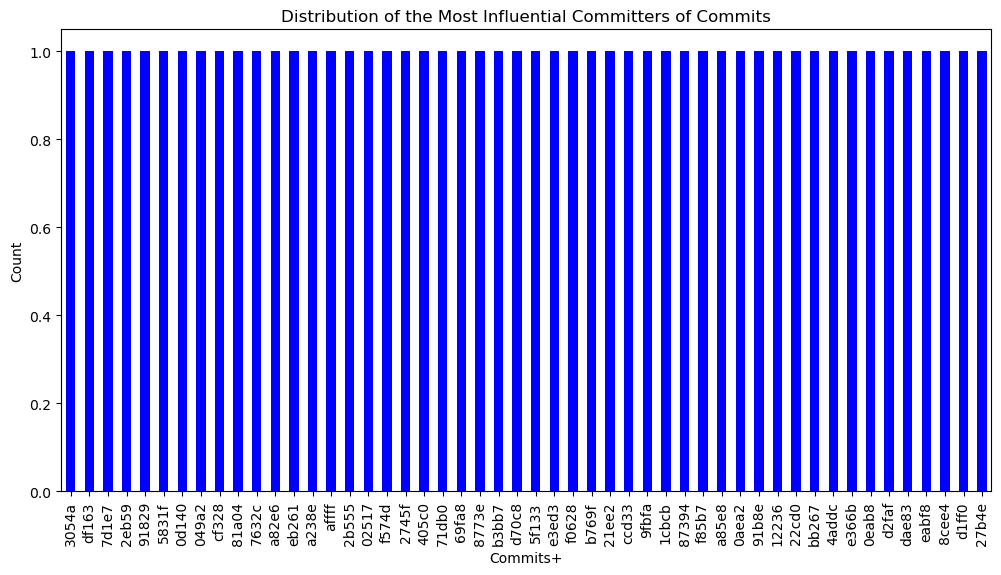

In [ ]:
def Commit_Total_Volume_Visual(com_df_9: DataFrame) -> DataFrame:
    from pyspark.sql import functions as F

    result_infl_com = com_df_9.groupBy("com_name").count().orderBy(F.desc("count"))
    most_commits_committer = result_infl_com.first()
    most_commits_committer_df = com_df_9.filter(com_df_9.com_name == most_commits_committer.com_name)

    return most_commits_committer_df

# Get the DataFrame containing the commits of the committer with the most commits
most_commits_committer_df = Commit_Total_Volume_Visual(com_df_9)

# Extract the first 5 characters of the commits
most_commits_committer_df = most_commits_committer_df.withColumn("commit_short", most_commits_committer_df["commit"].substr(1, 5))

# Limit the results to the top 100
most_commits_committer_df = most_commits_committer_df.limit(50)

# Convert the DataFrame to Pandas for easier plotting
most_commits_committer_pd = most_commits_committer_df.toPandas()

# Create a bar plot of the first 5 characters of the commits
ax = most_commits_committer_pd['commit_short'].value_counts().plot(kind='bar', color='blue', figsize=(12, 6))
plt.title('Distribution of the Most Influential Committers of Commits')
plt.xlabel('Commits+')
plt.ylabel('Count')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

#### 10. How unique are the “subject” and “message” values?

* Are they mostly unique? Or are people usually just copy-pasting the same text?
* You can use LSH to measure uniqueness / similarity
* Visualize “subject” and “message” duplication across all programming languages
* Visualize “subject” and “message” duplication for each of the top 5 programming languages
* Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [39]:
com_df_10 = com_df_1.rdd.toDF(schema_copy_com_1)
com_df_10 = com_df_10.sample(False, 0.0001)

In [40]:
com_df_10.show(5)

+--------------------+--------------------+----------------+-------------+--------------+------------+--------------------+--------------------+
|              commit|           repo_name|       auth_name|auth_time_sec|      com_name|com_time_sec|             subject|             message|
+--------------------+--------------------+----------------+-------------+--------------+------------+--------------------+--------------------+
|864c2591b6f086132...|[sysadmin75/ansib...|      Brian Coca|   2022-01-21|        GitHub|  2022-01-21|Use explicit keyw...|Use explicit keyw...|
|970eb1950e4900dff...|     [NLog/NLog.Web]|Julian Verdurmen|   2021-10-28|        GitHub|  2021-10-28|Release 5.0 previ...|Release 5.0 previ...|
|82a6351864e1d225a...|    [google/transit]|          scmcca|   2021-06-03|        scmcca|  2021-06-03|       feed_info.txt|      feed_info.txt
|
|d2f3f903f00bab9d6...|[Beep6581/RawTher...|    Thanatomanic|   2021-05-22|  Thanatomanic|  2021-05-22|Add reset button ...|Add res

In [41]:
com_sub_mes = com_df_10.select("repo_name", "subject", "message")
com_sub_mes = com_sub_mes.withColumn("repo_name", concat_ws(",", com_sub_mes["repo_name"]))
com_sub_mes.show(5)

+--------------------+--------------------+--------------------+
|           repo_name|             subject|             message|
+--------------------+--------------------+--------------------+
|sysadmin75/ansibl...|Use explicit keyw...|Use explicit keyw...|
|       NLog/NLog.Web|Release 5.0 previ...|Release 5.0 previ...|
|      google/transit|       feed_info.txt|      feed_info.txt
|
|Beep6581/RawTherapee|Add reset button ...|Add reset button ...|
|  bwmarrin/discordgo|Improve handling ...|Improve handling ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [42]:
lang_df_5 = lang_df.rdd.toDF(schema_copy_lang)
lang_df_5 = lang_df_5.drop('language_bytes')

**10.1** Are they mostly unique? Or are people usually just copy-pasting the same text?

* use LSH to measure uniqueness / similarity

In [ ]:
# Define English stop words using NLTK
english_stop_words = stopwords.words('english')

# Define a set of English words using NLTK
english_words = set(nltk.corpus.words.words())

# Define a function to remove emojis using regex
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F100-\U0001F1FF"  # enclosed alphanumeric supplement
        u"\U0001F300-\U0001FAFF"  # symbols & pictographs extended
        u"\U00002300-\U000023FF"  # miscellaneous technical
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U00002600-\U000026FF"  # miscellaneous symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U00002700-\U000027BF"  # dingbats
        u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess_text(df, text_column):
    # Define a pattern for ASCII only characters
    ascii_only_pattern = "[^ -~]"

    # Remove non-ASCII characters from the text column
    df = df.withColumn(text_column, regexp_replace(text_column, ascii_only_pattern, ""))

    # Define a user-defined function (UDF) to clean the text
    def clean_text(text):
        # Remove HTML tags using regexp_replace
        text = re.sub('<.*?>', '', text)

        # Remove URLs
        text = ' '.join(word for word in text.split() if not word.startswith('http'))

        # Remove Emojis
        text = deEmojify(text)

        # Tokenize the text
        words = text.split()

        # Remove stop words, infrequent words (only words which are longer than 2 letters), special characters, and non-English words
        cleaned_words = [word for word in words if word not in english_stop_words and len(word) > 2 and word.isalnum() and word.lower() in english_words]

        return " ".join(cleaned_words)

    clean_text_udf = udf(clean_text, StringType())

    # Clean the text column
    df = df.withColumn("cleaned_text", clean_text_udf(text_column))

    # Tokenize the 'cleaned_text' column
    tokenizer = Tokenizer(inputCol="cleaned_text", outputCol=f"{text_column}_words")
    df = tokenizer.transform(df)

    # Use HashingTF and IDF to transform text into feature vectors
    hashingTF = HashingTF(inputCol=f"{text_column}_words", outputCol=f"{text_column}_rawFeatures")
    idf = IDF(inputCol=f"{text_column}_rawFeatures", outputCol=f"{text_column}_features")

    # Create a pipeline and fit the model
    pipeline = Pipeline(stages=[hashingTF, idf])
    model = pipeline.fit(df)

    # Transform the data
    df = model.transform(df)

    # Use MinHashLSH to measure the similarity
    mh = MinHashLSH(inputCol=f"{text_column}_features", outputCol=f"{text_column}_hashes")
    model = mh.fit(df)

    # Transform the data
    df = model.transform(df)

    return df, model

com_sub_mes, model_sub_mes = preprocess_text(com_sub_mes, "subject")
com_sub_mes, model_sub_mes = preprocess_text(com_sub_mes, "message")

*  Set the **Jaccard Similarity** Threshold as **0.3**

In [ ]:
from pyspark.sql.functions import col

# Set the Jaccard similarity threshold
threshold_1 = 0.3

# Calculate the approximate similarity using MinHashLSH for title_df
sub_mes_results_1 = model_sub_mes.approxSimilarityJoin(com_sub_mes, com_sub_mes, threshold_1, distCol="subject_jaccard_distance")

# Filter out self-joins for subject_results_1
sub_mes_results_1 = sub_mes_results_1.filter(col("datasetA.repo_name") != col("datasetB.repo_name")).select(
                col("subject_jaccard_distance"),
                col("datasetA.repo_name").alias("repo_name_A"), 
                col("datasetB.repo_name").alias("repo_name_B"), 
                col("datasetA.subject").alias("subject_A"),
                col("datasetB.message").alias("message_B"))

**10.1.1** Count **Duplicate Subjects** and **Unique Subjects**

In [ ]:
from pyspark.sql import functions as F

# Group by subject_A, message_B, repo_name_A, and repo_name_B, and count the occurrences
sub_mes_counts_1 = sub_mes_results_1.groupBy('subject_A', 'message_B', 'repo_name_A', 'repo_name_B') \
    .agg(F.count('*').alias('count'))

# Count the number of unique and duplicate values in the 'subject_A' column
num_unique_subjects_A = sub_mes_counts_1.select("subject_A").distinct().count()
num_duplicate_subjects_A = sub_mes_counts_1.count() - num_unique_subjects_A

# Count the number of unique and duplicate values in the 'message_B' column
num_unique_messages_B = sub_mes_counts_1.select("message_B").distinct().count()
num_duplicate_messages_B = sub_mes_counts_1.count() - num_unique_messages_B

23/12/09 18:41:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.4 MiB
23/12/09 18:41:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 18:41:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.1 MiB
23/12/09 18:41:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 18:41:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 19:01:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.4 MiB
23/12/09 19:01:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 19:01:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.1 MiB
23/12/09 19:01:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary w

**10.1.1 (1)** Number of Duplicate Subject **A** & Number of Unique Subject **A**

In [46]:
print("Number of duplicate subject A with Jaccard Similarity Threshold = 0.3: ", num_duplicate_subjects_A)
print("\n")

print("Number of unique subject A with Jaccard Similarity Threshold = 0.3: ", num_unique_subjects_A)

Number of duplicate subject A with Jaccard Similarity Threshold = 0.3:  80279


Number of unique subject A with Jaccard Similarity Threshold = 0.3:  961


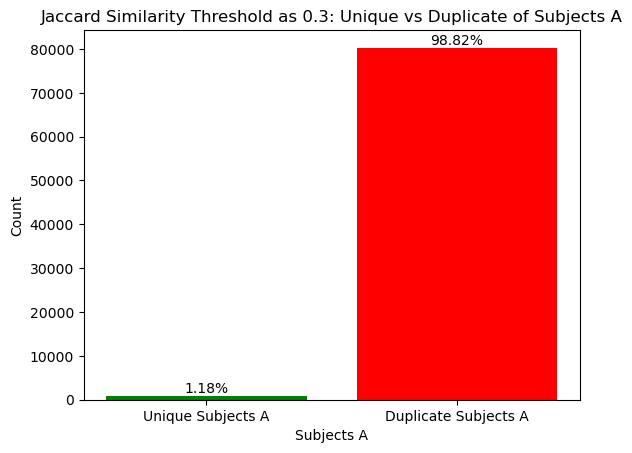

In [47]:
# Count total subjects A
total_subjects_A = num_unique_subjects_A + num_duplicate_subjects_A

# Specify colors for each category
colors = ['green', 'red']

# Plot the count of duplicate subjects A vs unique subjects A
bars = plt.bar(['Unique Subjects A', 'Duplicate Subjects A'], [num_unique_subjects_A, num_duplicate_subjects_A], color = colors)
plt.xlabel('Subjects A')
plt.ylabel('Count')
plt.title('Jaccard Similarity Threshold as 0.3: Unique vs Duplicate of Subjects A')

# Add percentages to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{round(yval/total_subjects_A*100, 2)}%", ha='center', va='bottom')

plt.show()

**10.1.1 (2)** Number of Duplicate Message **B** & Number of Unique Message **B**

In [48]:
print("Number of duplicate message B with Jaccard Similarity Threshold = 0.3: ", num_duplicate_messages_B)
print("\n")

print("Number of unique message B with Jaccard Similarity Threshold = 0.3: ", num_unique_messages_B)

Number of duplicate message B with Jaccard Similarity Threshold = 0.3:  80269


Number of unique message B with Jaccard Similarity Threshold = 0.3:  971


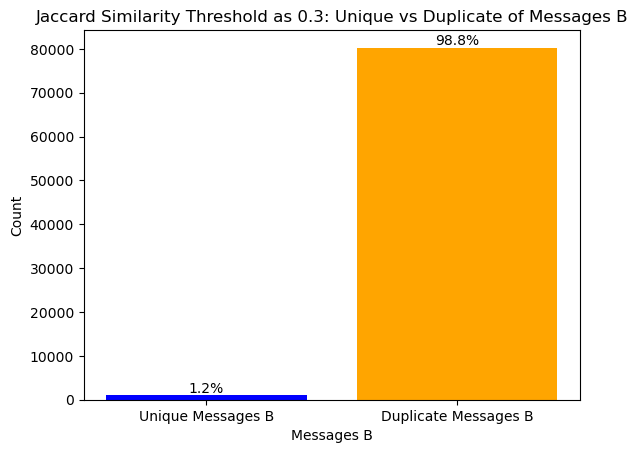

In [49]:
# Count total subjects B
total_messages_B = num_unique_messages_B + num_duplicate_messages_B

# Specify colors for each category
colors = ['blue', 'orange']

# Plot the count of duplicate texts vs unique texts
bars = plt.bar(['Unique Messages B', 'Duplicate Messages B'], [num_unique_messages_B, num_duplicate_messages_B], color = colors)
plt.xlabel('Messages B')
plt.ylabel('Count')
plt.title('Jaccard Similarity Threshold as 0.3: Unique vs Duplicate of Messages B')

# Add percentages to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{round(yval/total_messages_B*100, 2)}%", ha='center', va='bottom')

plt.show()

**10.2** Visualize **subject** and **message** duplication across all programming languages

In [ ]:
schema_copy_mes_sub = copy.deepcopy(sub_mes_results_1.schema)

subject_content_1 = sub_mes_results_1.rdd.toDF(schema_copy_mes_sub)

message_content_1 = sub_mes_results_1.rdd.toDF(schema_copy_mes_sub)

subject_content_1 = subject_content_1.select("repo_name_A", "subject_A")

message_content_1 = message_content_1.select("repo_name_B", "message_B")


23/12/09 20:42:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.4 MiB


In [51]:
from pyspark.sql.functions import col
# For Subject Dataframe

# Remove "HTTP" links
subject_content_1 = subject_content_1.withColumn("subject_A", regexp_replace(col("subject_A"), "http\S+", ""))


# Remove non-English characters
subject_content_1 = subject_content_1.withColumn("subject_A", regexp_replace(col("subject_A"), "[^a-zA-Z\s]", ""))


# Remove white spaces
subject_content_1 = subject_content_1.withColumn("subject_A", trim(col("subject_A")))

# Remove null values
subject_content_1 = subject_content_1.na.drop(subset=["subject_A"])


# From Message Dataframe

# Remove "HTTP" links

message_content_1 = message_content_1.withColumn("message_B", regexp_replace(col("message_B"), "http\S+", ""))

# Remove non-English characters

message_content_1 = message_content_1.withColumn("message_B", regexp_replace(col("message_B"), "[^a-zA-Z\s]", ""))


# Remove white spaces

message_content_1 = message_content_1.withColumn("message_B", trim(col("message_B")))

# Remove null values
message_content_1 = message_content_1.na.drop(subset=["message_B"])

**10.2.1** Visualize **message** duplication across all programming languages

In [52]:
# Step 1: Join the dataframes
joined_mes_dup = message_content_1.join(lang_df_5, message_content_1.repo_name_B == lang_df_5.repo_name, how='outer')

# Remove rows where language_name is null
joined_mes_dup = joined_mes_dup.filter(col("language_name").isNotNull())

# Step 2: Group by language_name, message_A, and message_B, and count the occurrences
duplication_message_df = joined_mes_dup.groupBy('language_name', 'message_B').agg(F.count('*').alias('count'))

# To get the total number of duplicates for each language, group by language_name and sum the counts
language_dup_message_df = duplication_message_df.groupBy('language_name').agg(F.sum('count').alias('total_duplicates'))

# Show the result
# language_dup_message_df.show()

23/12/09 20:49:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:50:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:50:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:50:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB


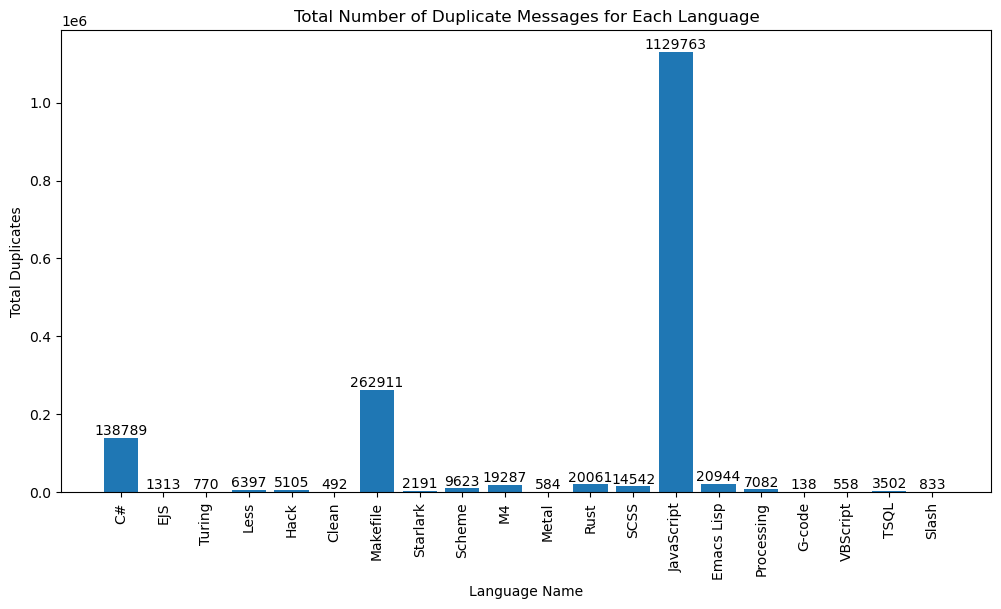

In [53]:
# Collect the data to the driver as a list of rows
message_dup_rows = language_dup_message_df.collect()

# Create a Pandas DataFrame from the list of rows
message_dup_df = pd.DataFrame(message_dup_rows, columns=language_dup_message_df.columns)
limited_message_dup_df = message_dup_df.head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(limited_message_dup_df['language_name'], limited_message_dup_df['total_duplicates'])
plt.xlabel('Language Name')
plt.ylabel('Total Duplicates')
plt.title('Total Number of Duplicate Messages for Each Language')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add the number of occurrences for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()

**10.2.2** Visualize **subject** duplication across all programming languages

In [54]:
# Step 1: Join the dataframes
joined_sub_dup = subject_content_1.join(lang_df_5, subject_content_1.repo_name_A == lang_df_5.repo_name, how='outer')

# Remove rows where language_name is null
joined_sub_dup = joined_sub_dup.filter(col("language_name").isNotNull())

# Step 2: Group by language_name, message_A, and message_B, and count the occurrences
duplication_subject_df = joined_sub_dup.groupBy('language_name', 'subject_A').agg(F.count('*').alias('count'))

# To get the total number of duplicates for each language, group by language_name and sum the counts
language_dup_subject_df = duplication_subject_df.groupBy('language_name').agg(F.sum('count').alias('total_duplicates'))

# Show the result
# language_dup_subject_df.show()

23/12/09 20:56:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:57:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:57:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:57:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB


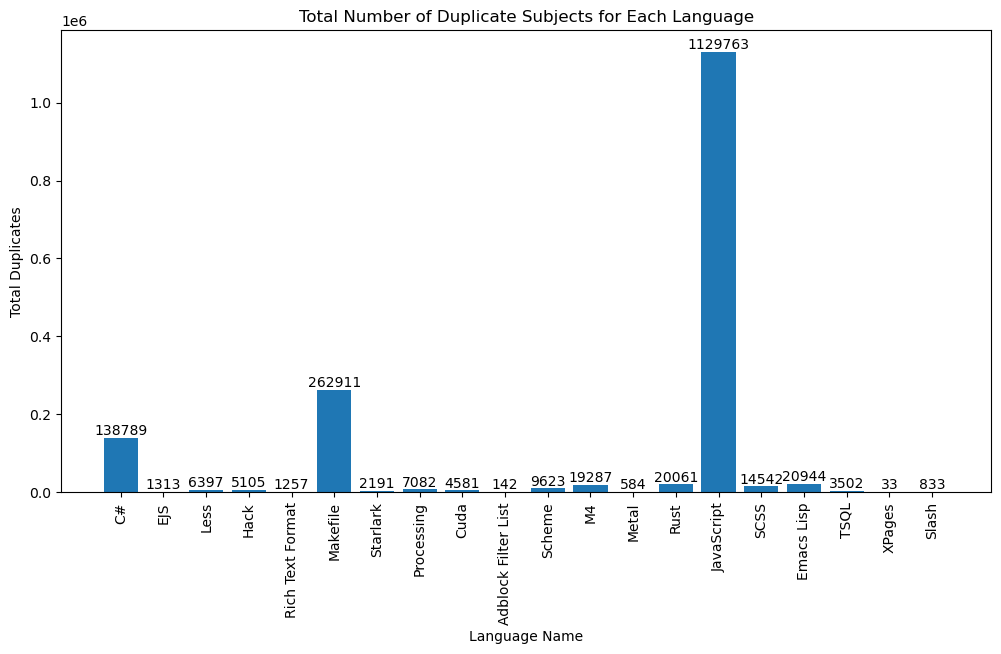

In [55]:
# Collect the data to the driver as a list of rows
subject_dup_rows = language_dup_subject_df.collect()

# Create a Pandas DataFrame from the list of rows
subject_dup_df = pd.DataFrame(subject_dup_rows, columns=language_dup_subject_df.columns)

limited_subject_dup_df = subject_dup_df.head(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(limited_subject_dup_df['language_name'], limited_subject_dup_df['total_duplicates'])
plt.xlabel('Language Name')
plt.ylabel('Total Duplicates')
plt.title('Total Number of Duplicate Subjects for Each Language')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add the number of occurrences for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()

**10.3** Visualize **subject** and **message** duplication for each of the top 5 programming languages

**10.3.1** Visualize **message** duplication for each of the top 5 programming languages

In [56]:
# Step 1: Join the dataframes
joined_mes_dup_top = message_content_1.join(lang_df_5, message_content_1.repo_name_B == lang_df_5.repo_name, how='outer')

# Remove rows where language_name is null
joined_mes_dup_top = joined_mes_dup_top.filter(col("language_name").isNotNull())

# Step 2: Group by language_name, message_A, and message_B, and count the occurrences
duplication_message_top_df = joined_mes_dup_top.groupBy('language_name', 'message_B').agg(F.count('*').alias('count'))

# To get the total number of duplicates for each language, group by language_name and sum the counts
language_dup_message_top_df = duplication_message_top_df.groupBy('language_name').agg(F.sum('count').alias('total_duplicates'))

# Find the top 5 languages by total_duplicates
top_5_mes_languages = language_dup_message_top_df.sort(col("total_duplicates").desc()).limit(5).select("language_name")

# Filter the duplication_message_df to include only the top 5 languages
top_5_mes_languages_duplication = language_dup_message_top_df.join(top_5_mes_languages, on="language_name", how="inner")

# Show the result
# top_5_mes_languages_duplication.show()

23/12/09 20:57:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:58:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:58:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:58:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:58:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:58:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB


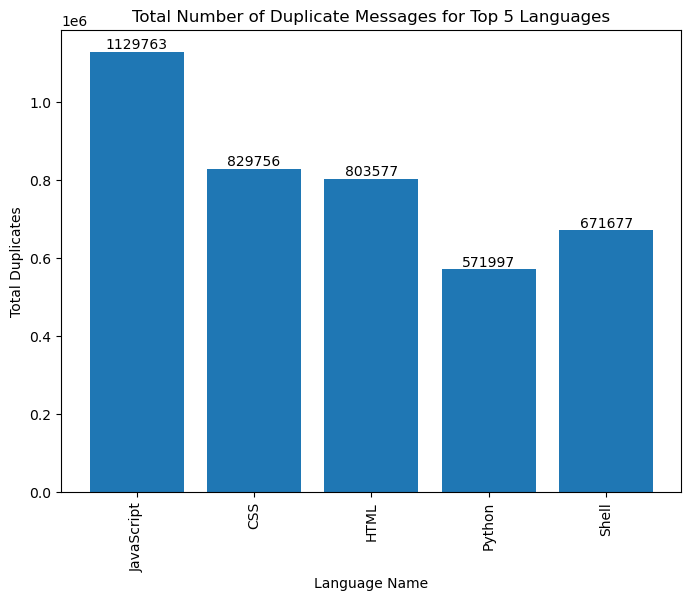

In [57]:
top_5_mes_languages_duplication_df = top_5_mes_languages_duplication.toPandas()

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(top_5_mes_languages_duplication_df['language_name'], top_5_mes_languages_duplication_df['total_duplicates'])
plt.xlabel('Language Name')
plt.ylabel('Total Duplicates')
plt.title('Total Number of Duplicate Messages for Top 5 Languages')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add the number of occurrences for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()

**10.3.1** Visualize **subject** duplication for each of the top 5 programming languages

In [58]:
# Step 1: Join the dataframes
joined_sub_dup_top = subject_content_1.join(lang_df_5, subject_content_1.repo_name_A == lang_df_5.repo_name, how='outer')

# Remove rows where language_name is null
joined_sub_dup_top = joined_sub_dup_top.filter(col("language_name").isNotNull())

# Step 2: Group by language_name, message_A, and message_B, and count the occurrences
duplication_subject_top_df = joined_sub_dup_top.groupBy('language_name', 'subject_A').agg(F.count('*').alias('count'))

# To get the total number of duplicates for each language, group by language_name and sum the counts
language_dup_subject_top_df = duplication_subject_top_df.groupBy('language_name').agg(F.sum('count').alias('total_duplicates'))

# Find the top 5 languages by total_duplicates
top_5_sub_languages = language_dup_subject_top_df.sort(col("total_duplicates").desc()).limit(5).select("language_name")

# Filter the duplication_message_df to include only the top 5 languages
top_5_sub_languages_duplication = language_dup_subject_top_df.join(top_5_sub_languages, on="language_name", how="inner")

23/12/09 20:58:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:59:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:59:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:59:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:59:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
23/12/09 20:59:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB


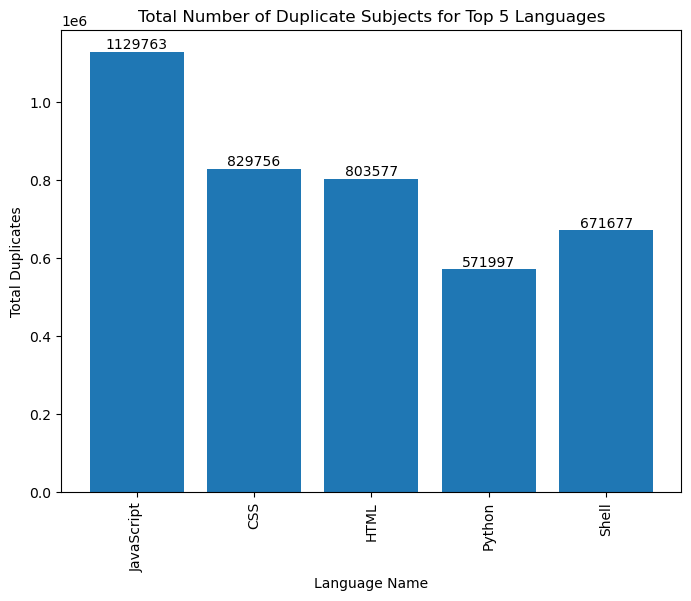

In [59]:
top_5_sub_languages_duplication_df = top_5_sub_languages_duplication.toPandas()

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(top_5_sub_languages_duplication_df['language_name'], top_5_sub_languages_duplication_df['total_duplicates'])
plt.xlabel('Language Name')
plt.ylabel('Total Duplicates')
plt.title('Total Number of Duplicate Subjects for Top 5 Languages')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add the number of occurrences for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()

## LDA Modeling

In [ ]:
com_df_11 = com_df_1.rdd.toDF(schema_copy_com_1)
com_sub_mes_md = com_df_11.select("repo_name", "subject", "message", "com_time_sec")
com_sub_mes_md = com_sub_mes_md.withColumn("repo_name", concat_ws(",", com_sub_mes_md["repo_name"]))

In [ ]:
# Define English stop words using NLTK
english_stop_words = stopwords.words('english')

# Define a set of English words using NLTK
english_words = set(nltk.corpus.words.words())

# Define a function to remove emojis using regex
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F100-\U0001F1FF"  # enclosed alphanumeric supplement
        u"\U0001F300-\U0001FAFF"  # symbols & pictographs extended
        u"\U00002300-\U000023FF"  # miscellaneous technical
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U00002600-\U000026FF"  # miscellaneous symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U00002700-\U000027BF"  # dingbats
        u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess_text(df, text_column):
    # Define a pattern for ASCII only characters
    ascii_only_pattern = "[^ -~]"

    # Remove non-ASCII characters from the text column
    df = df.withColumn(text_column, regexp_replace(text_column, ascii_only_pattern, ""))

    # Define a user-defined function (UDF) to clean the text
    def clean_text(text):
        # Remove HTML tags using regexp_replace
        text = re.sub('<.*?>', '', text)

        # Remove URLs
        text = ' '.join(word for word in text.split() if not word.startswith('http'))

        # Remove Emojis
        text = deEmojify(text)

        # Tokenize the text
        words = text.split()

        # Remove stop words, infrequent words (only words which are longer than 2 letters), special characters, and non-English words
        cleaned_words = [word for word in words if word not in english_stop_words and len(word) > 2 and word.isalnum() and word.lower() in english_words]

        return " ".join(cleaned_words)

    clean_text_udf = udf(clean_text, StringType())

    # Clean the text column
    df = df.withColumn("cleaned_text", clean_text_udf(text_column))

    # Tokenize the 'cleaned_text' column
    tokenizer = Tokenizer(inputCol="cleaned_text", outputCol=f"{text_column}_words")
    df = tokenizer.transform(df)

    # Count Vectorizer
    cv = CountVectorizer(inputCol=f"{text_column}_words", outputCol=f"{text_column}_features")
    model = cv.fit(df)

    # Transform the data
    df = model.transform(df)

    return df, model

com_sub_mes_md, model_sub_mes_md = preprocess_text(com_sub_mes_md, "subject")
com_sub_mes_md, model_sub_mes_md = preprocess_text(com_sub_mes_md, "message")

##### Train LDA model

In [ ]:
com_sub_feat = com_sub_mes_md.select('repo_name', 'com_time_sec', 'subject_features')
com_mes_feat = com_sub_mes_md.select('repo_name', 'com_time_sec', 'message_features')

In [ ]:
lda = LDA(k=10, maxIter=10)

# For "subject" dataframe
lda.setFeaturesCol("subject_features")
lda_model_sub = lda.fit(com_sub_feat)
transformed_sub = lda_model_sub.transform(com_sub_feat)

# For "message" dataframe
lda.setFeaturesCol("message_features")
lda_model_mes = lda.fit(com_mes_feat)
transformed_mes = lda_model_mes.transform(com_mes_feat)

In [ ]:
# Get the vocabulary from the CountVectorizer model for subject_features
vocab_subject = model_sub_mes_md.vocabulary

# Describe the topics for subject_features
lda_subject_topics = lda_subject_model.describeTopics()

# Map term indices to words for subject_features
map_term_indices_to_words_udf = udf(lambda term_indices: [vocab_subject[index] for index in term_indices], ArrayType(StringType()))

# Add a new column with the words for each topic for subject_features
lda_subject_topics = lda_subject_topics.withColumn("terms", map_term_indices_to_words_udf("termIndices"))

# Show the topics with words for subject_features
lda_subject_topics.select("topic", "terms").show(truncate=False)

In [ ]:
# Get the vocabulary from the CountVectorizer model for message_features
vocab_message = model_sub_mes_md.vocabulary

# Describe the topics for message_features
lda_message_topics = lda_message_model.describeTopics()

# Map term indices to words for message_features
map_term_indices_to_words_udf = udf(lambda term_indices: [vocab_message[index] for index in term_indices], ArrayType(StringType()))

# Add a new column with the words for each topic for message_features
lda_message_topics = lda_message_topics.withColumn("terms", map_term_indices_to_words_udf("termIndices"))

# Show the topics with words for message_features
lda_message_topics.select("topic", "terms").show(truncate=False)